In [1]:
import gzip
import pickle
import glob
import pandas as pd
import numpy as np
from metient.util import eval_util as eutil
from metient.util.globals import *
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation
import itertools

REPO_DIR = os.path.join(os.getcwd(), "../")

METRICS = ["Migration", "Comigration", "Seeding site"]
DATASET_NAMES = [ "HGSOC", "Melanoma", "Neuroblastoma", "NSCLC"]
#os.path.join(REPO_DIR,"data/hoadley_breast_cancer_2016/metient_outputs/calibrate")
CALIBRATE_DIRS = [os.path.join(REPO_DIR,"data/mcpherson_ovarian_2016/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/sanborn_melanoma_2015/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/gundem_neuroblastoma_2023/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/tracerx_nsclc/metient_outputs/pyclone_clustered_conipher_trees_03032024/calibrate")]
num_bootstrap_samples = 50

num_mets = []
dataset_to_pickle_files = {dataset:[] for dataset in DATASET_NAMES}
for dataset_name, calibrate_dir in zip(DATASET_NAMES, CALIBRATE_DIRS):
    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    for fn in matching_files:
        with gzip.open(fn, 'rb') as f:
            pkl = pickle.load(f)
            num_sites = len(pkl[OUT_SITES_KEY])
            loss_dicts = pkl[OUT_LOSS_DICT_KEY]
            #if num_sites > 2:
            dataset_to_pickle_files[dataset_name].append((fn, num_sites))
            num_mets.append(num_sites)

def convert_thetas_to_alt_metrics(thetas):
    wtot = thetas[0] + thetas[1]
    delta = thetas[1]/wtot
    return wtot, delta, thetas[2]
    
sizes = {k:len(v) for k,v in dataset_to_pickle_files.items()}
sizes


['/lila/data/morrisq/divyak/projects/metient/metient', '/lila/home/koyyald/mambaforge/envs/met/lib/python38.zip', '/lila/home/koyyald/mambaforge/envs/met/lib/python3.8', '/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/lib-dynload', '', '/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages', '/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/zstd-1.5.2.0-py3.8-linux-x86_64.egg', '/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/tqdm-4.44.1-py3.8.egg', '/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/torchopt-0.7.3-py3.8.egg', '/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/torch-2.1.1-py3.8-linux-x86_64.egg', '/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/setuptools-46.1.3-py3.8.egg', '/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/seaborn-0.10.0-py3.8.egg', '/lila/home/koyyald/mambaforge/envs/met/lib/python3.8/site-packages/scipy-1.9.3-py3.8-linux-x86_6

ModuleNotFoundError: No module named 'metient.lib'; 'metient' is not a package

### How consistent are the thetas when calibrated on random samples within the same cancer type cohort?


**** RUN 1 ***
Calibrating to 7 patients
Optimized thetas: tensor([0.6842, 0.1579, 0.1579], grad_fn=<DivBackward0>)


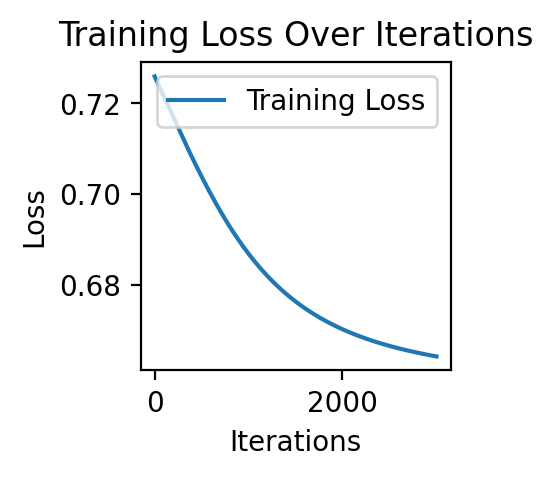

Calibrating to 8 patients
Optimized thetas: tensor([0.5874, 0.2521, 0.1604], grad_fn=<DivBackward0>)


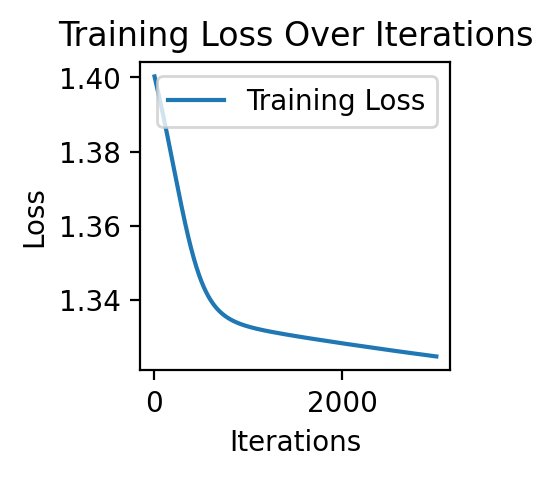

Calibrating to 26 patients
Early stopping after 1051 epochs.
Optimized thetas: tensor([0.4203, 0.3028, 0.2768], grad_fn=<DivBackward0>)


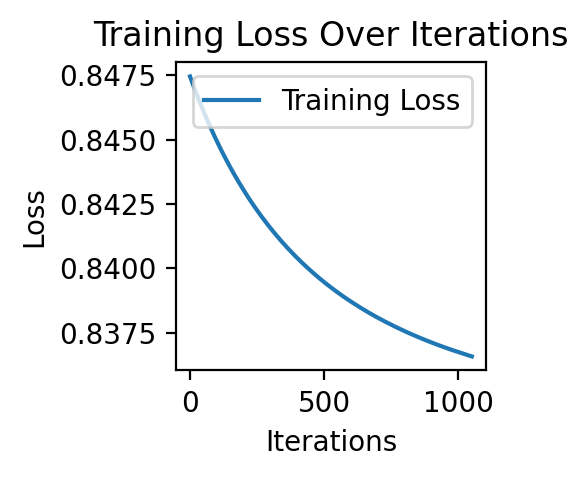

Calibrating to 128 patients
Early stopping after 2092 epochs.
Optimized thetas: tensor([0.5550, 0.2217, 0.2233], grad_fn=<DivBackward0>)


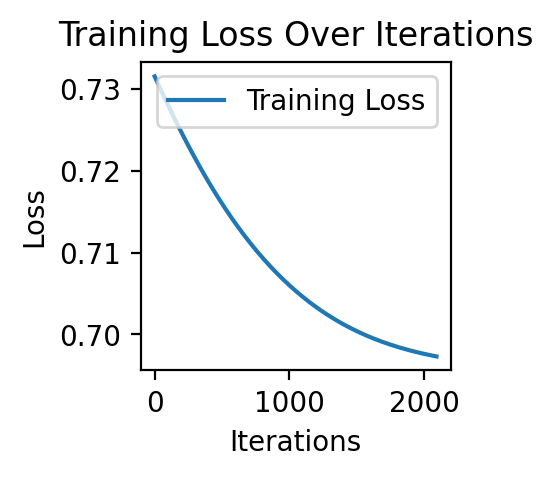


**** RUN 2 ***
Calibrating to 7 patients
Early stopping after 1900 epochs.
Optimized thetas: tensor([0.6865, 0.1567, 0.1567], grad_fn=<DivBackward0>)


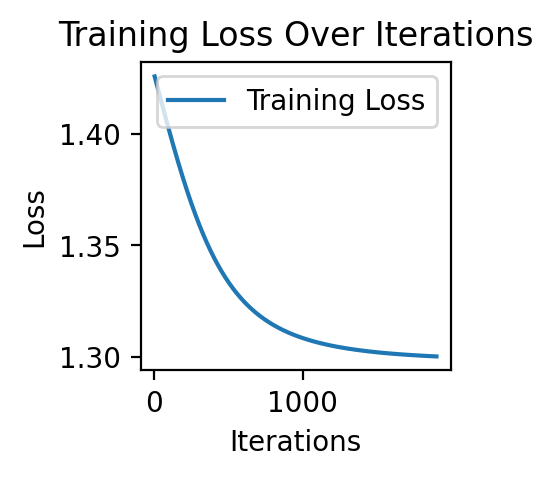

Calibrating to 8 patients
Optimized thetas: tensor([0.5970, 0.2838, 0.1192], grad_fn=<DivBackward0>)


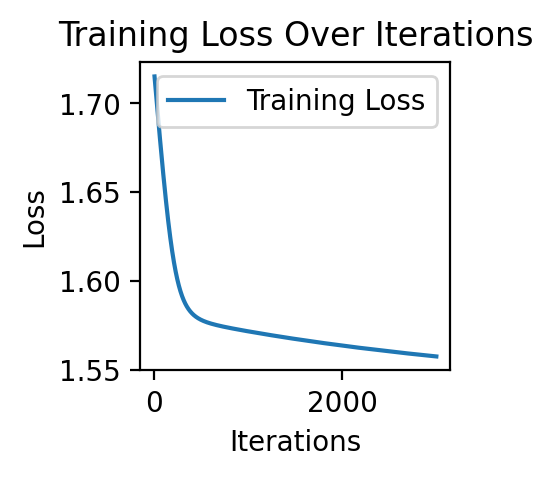

Calibrating to 26 patients
Early stopping after 1860 epochs.
Optimized thetas: tensor([0.5542, 0.2537, 0.1921], grad_fn=<DivBackward0>)


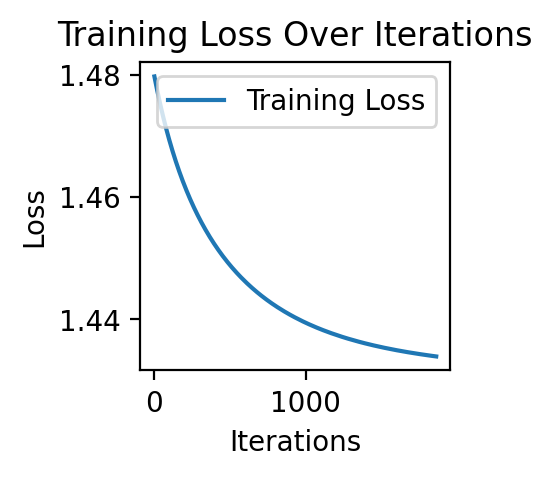

Calibrating to 128 patients
Early stopping after 1723 epochs.
Optimized thetas: tensor([0.5647, 0.2247, 0.2106], grad_fn=<DivBackward0>)


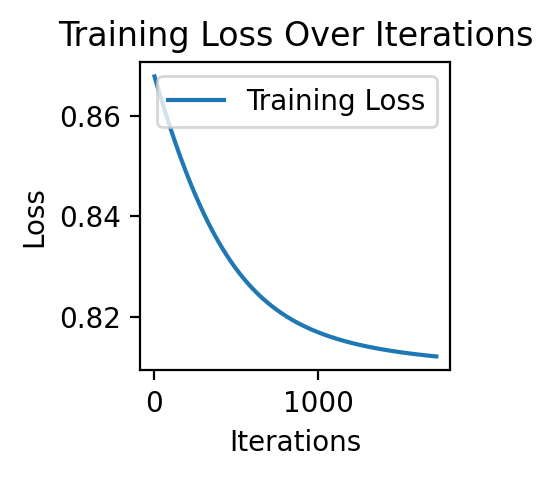


**** RUN 3 ***
Calibrating to 7 patients
Early stopping after 2752 epochs.
Optimized thetas: tensor([0.7597, 0.1201, 0.1201], grad_fn=<DivBackward0>)


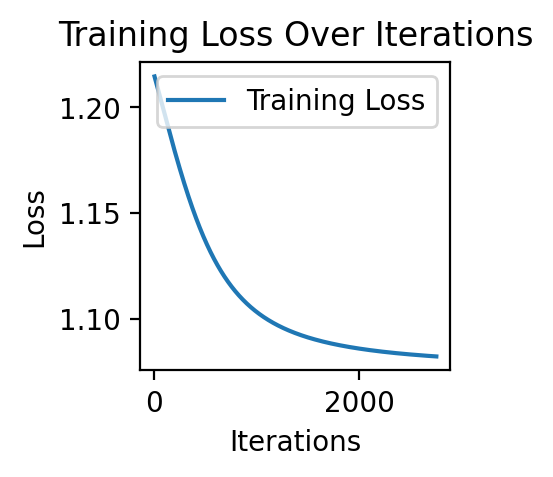

Calibrating to 8 patients
Optimized thetas: tensor([0.6341, 0.2955, 0.0703], grad_fn=<DivBackward0>)


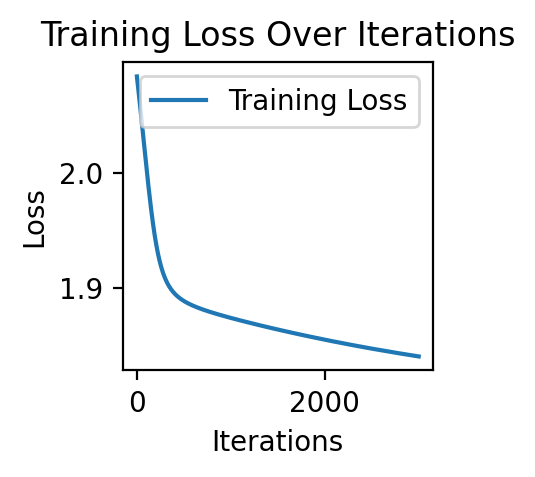

Calibrating to 26 patients
Optimized thetas: tensor([0.7285, 0.1773, 0.0942], grad_fn=<DivBackward0>)


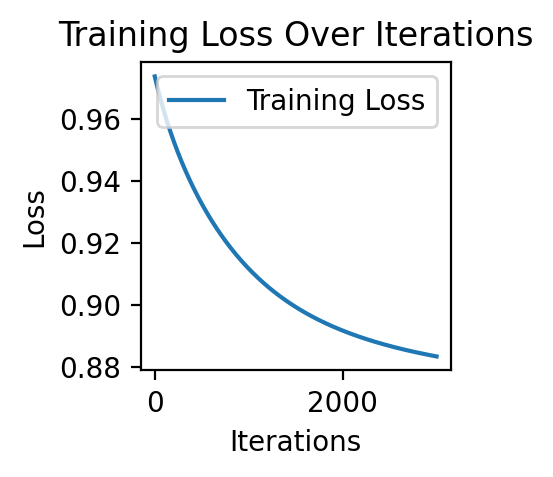

Calibrating to 128 patients
Early stopping after 1880 epochs.
Optimized thetas: tensor([0.5287, 0.2445, 0.2268], grad_fn=<DivBackward0>)


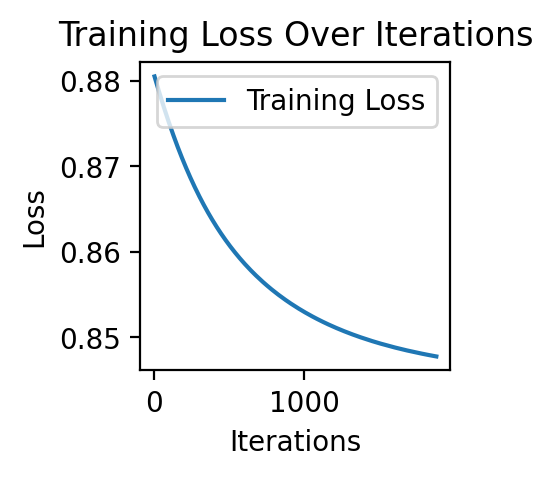


**** RUN 4 ***
Calibrating to 7 patients
Optimized thetas: tensor([0.6842, 0.1579, 0.1579], grad_fn=<DivBackward0>)


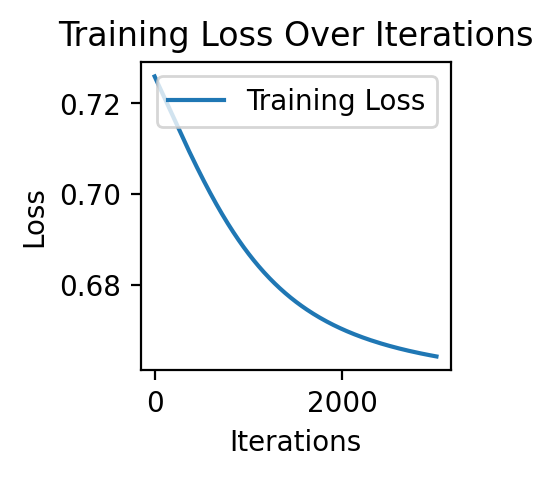

Calibrating to 8 patients
Optimized thetas: tensor([0.8069, 0.1134, 0.0797], grad_fn=<DivBackward0>)


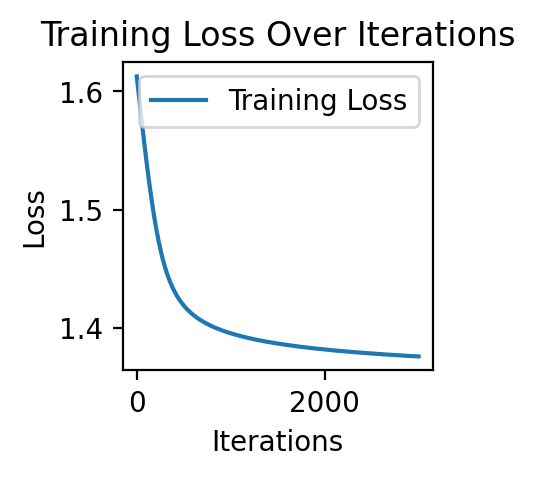

Calibrating to 26 patients
Early stopping after 1871 epochs.
Optimized thetas: tensor([0.6071, 0.2227, 0.1701], grad_fn=<DivBackward0>)


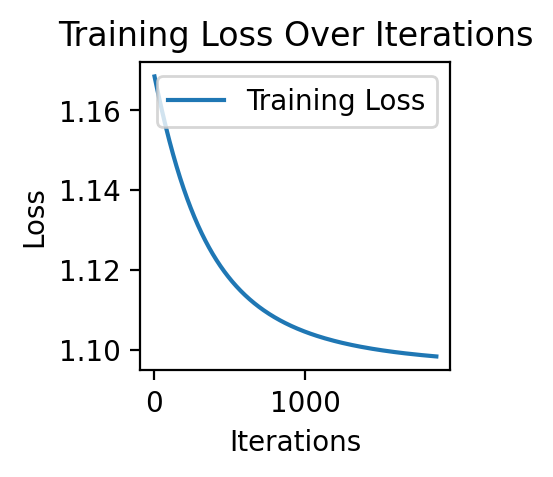

Calibrating to 128 patients
Early stopping after 1750 epochs.
Optimized thetas: tensor([0.4794, 0.2491, 0.2716], grad_fn=<DivBackward0>)


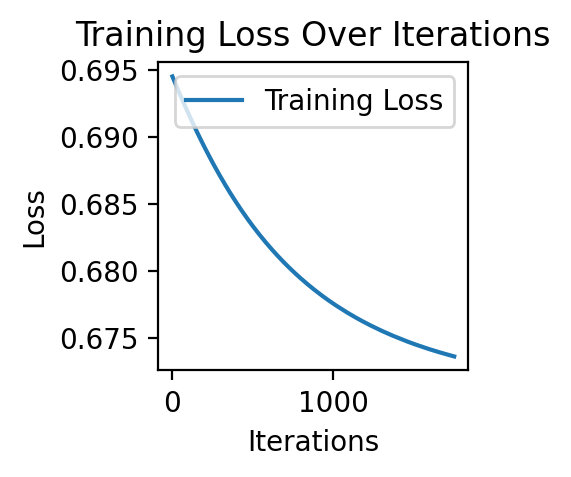


**** RUN 5 ***
Calibrating to 7 patients
Early stopping after 1424 epochs.
Optimized thetas: tensor([0.4619, 0.2690, 0.2690], grad_fn=<DivBackward0>)


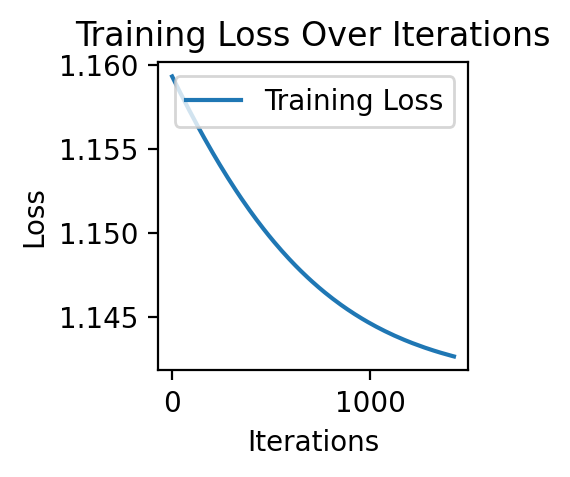

Calibrating to 8 patients
Early stopping after 1125 epochs.
Optimized thetas: tensor([0.4621, 0.2321, 0.3057], grad_fn=<DivBackward0>)


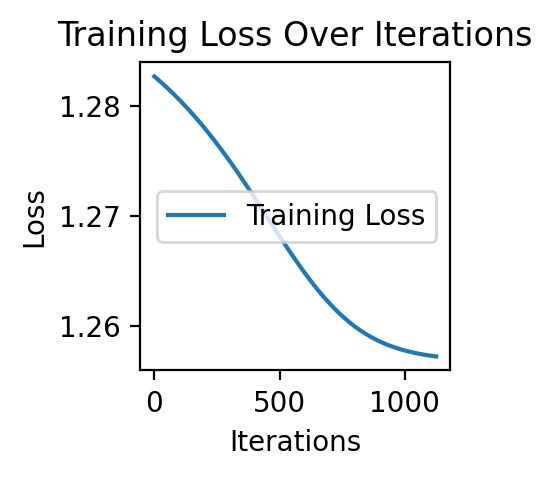

Calibrating to 26 patients
Early stopping after 2379 epochs.
Optimized thetas: tensor([0.5560, 0.2768, 0.1672], grad_fn=<DivBackward0>)


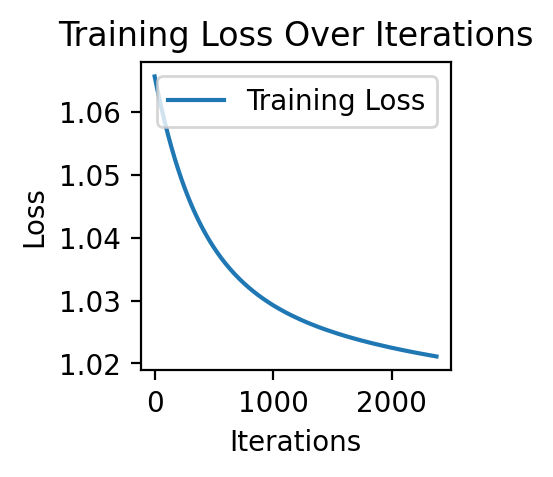

Calibrating to 128 patients
Early stopping after 1347 epochs.
Optimized thetas: tensor([0.4909, 0.2627, 0.2465], grad_fn=<DivBackward0>)


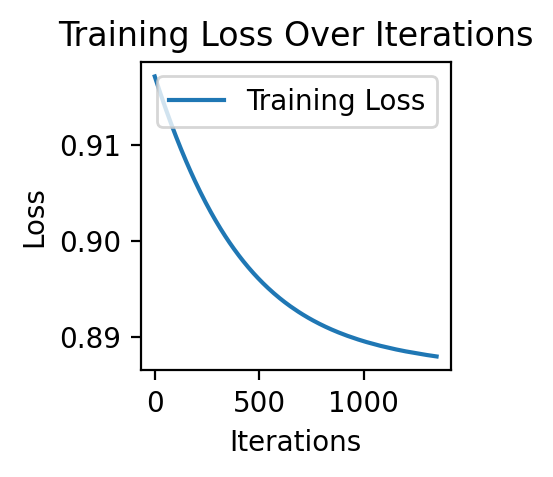


**** RUN 6 ***
Calibrating to 7 patients
Early stopping after 1232 epochs.
Optimized thetas: tensor([0.4797, 0.2602, 0.2602], grad_fn=<DivBackward0>)


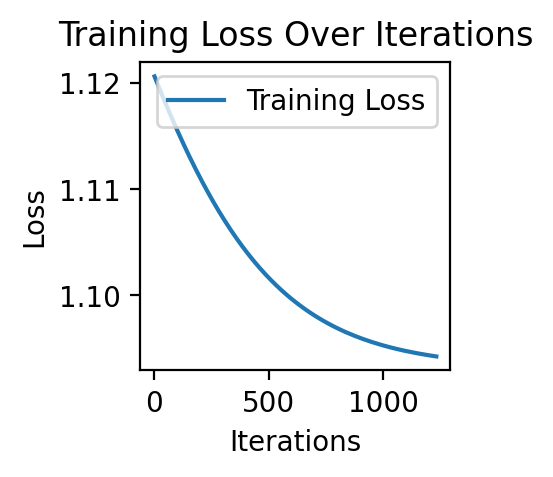

Calibrating to 8 patients
Optimized thetas: tensor([0.8268, 0.0866, 0.0866], grad_fn=<DivBackward0>)


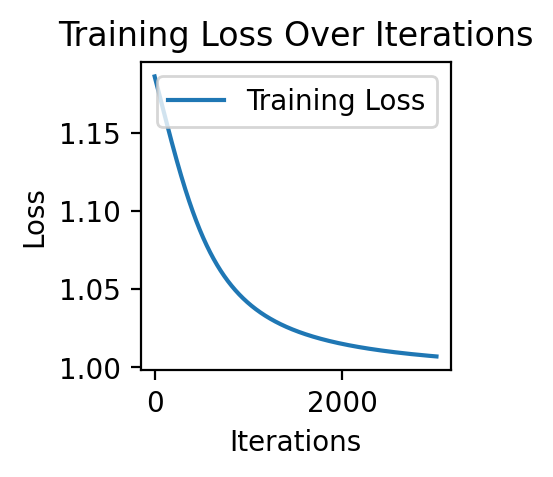

Calibrating to 26 patients
Early stopping after 1572 epochs.
Optimized thetas: tensor([0.5871, 0.2105, 0.2023], grad_fn=<DivBackward0>)


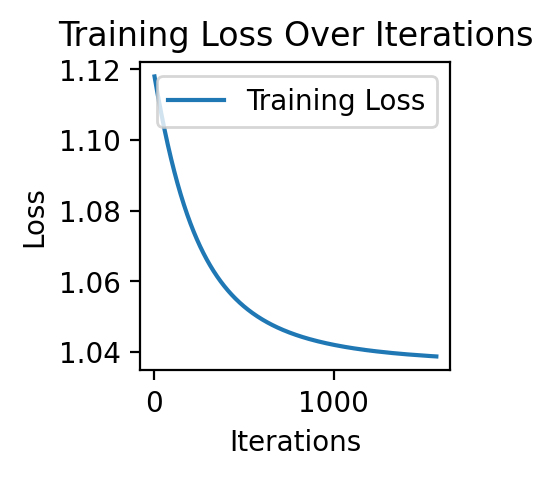

Calibrating to 128 patients
Early stopping after 1712 epochs.
Optimized thetas: tensor([0.4924, 0.2750, 0.2326], grad_fn=<DivBackward0>)


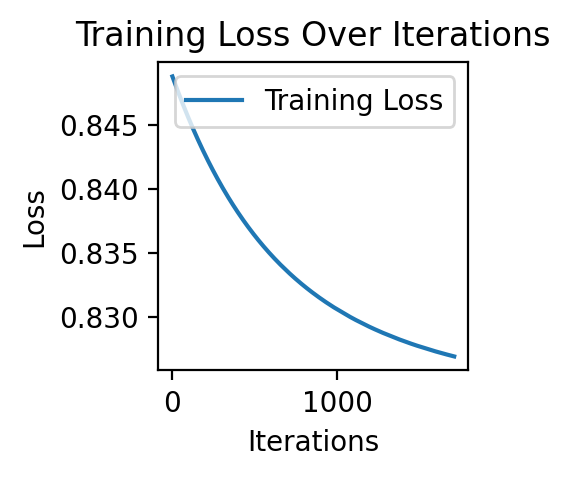


**** RUN 7 ***
Calibrating to 7 patients
Early stopping after 1455 epochs.
Optimized thetas: tensor([0.6440, 0.1780, 0.1780], grad_fn=<DivBackward0>)


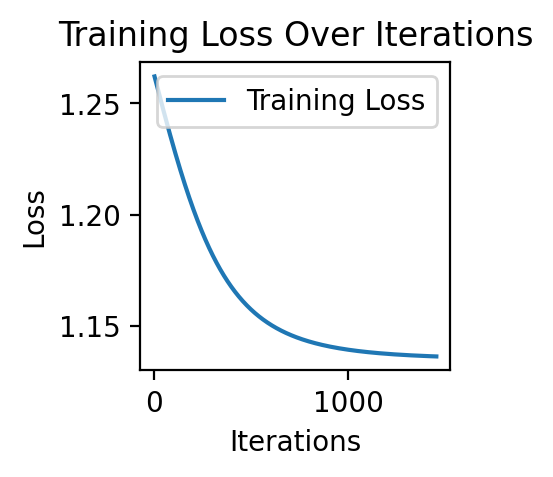

Calibrating to 8 patients
Optimized thetas: tensor([0.8268, 0.0866, 0.0866], grad_fn=<DivBackward0>)


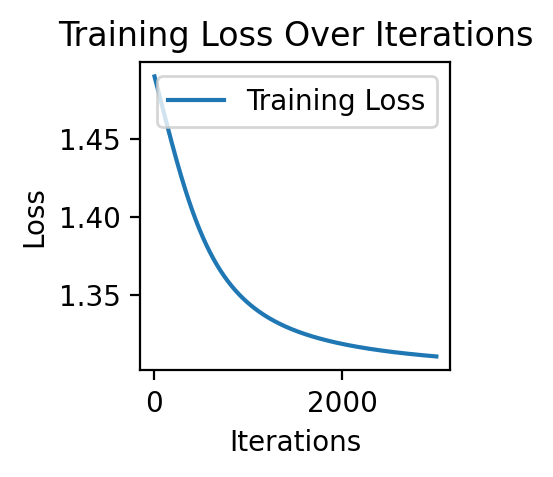

Calibrating to 26 patients
Early stopping after 2347 epochs.
Optimized thetas: tensor([0.6324, 0.2249, 0.1428], grad_fn=<DivBackward0>)


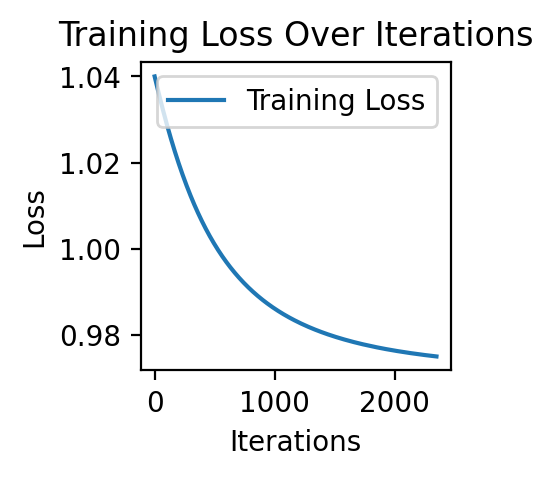

Calibrating to 128 patients
Early stopping after 1707 epochs.
Optimized thetas: tensor([0.5210, 0.2367, 0.2423], grad_fn=<DivBackward0>)


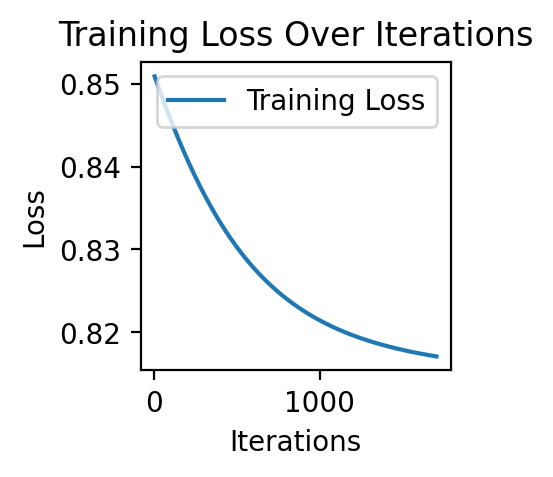


**** RUN 8 ***
Calibrating to 7 patients
Optimized thetas: tensor([0.6842, 0.1579, 0.1579], grad_fn=<DivBackward0>)


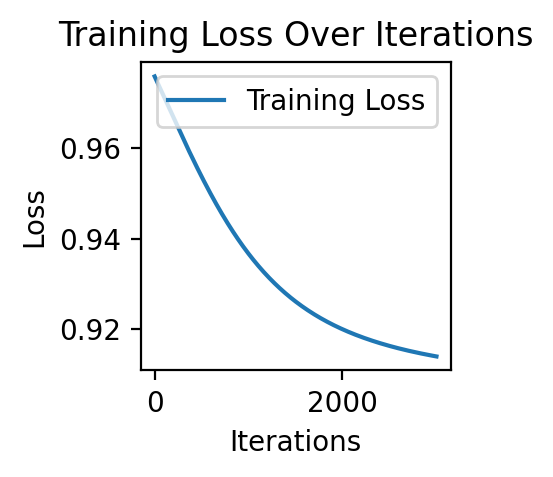

Calibrating to 8 patients
Optimized thetas: tensor([0.8069, 0.1134, 0.0797], grad_fn=<DivBackward0>)


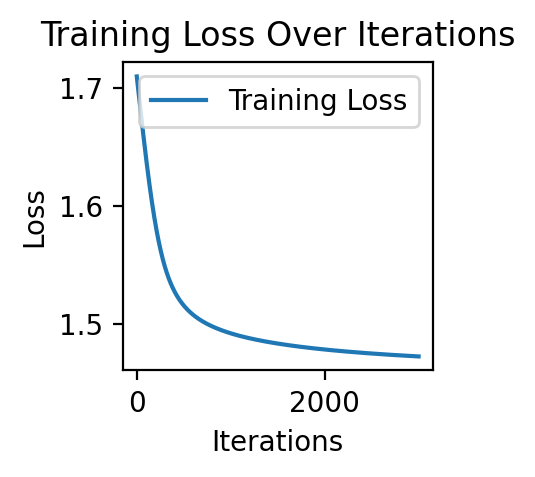

Calibrating to 26 patients
Optimized thetas: tensor([0.4998, 0.3659, 0.1343], grad_fn=<DivBackward0>)


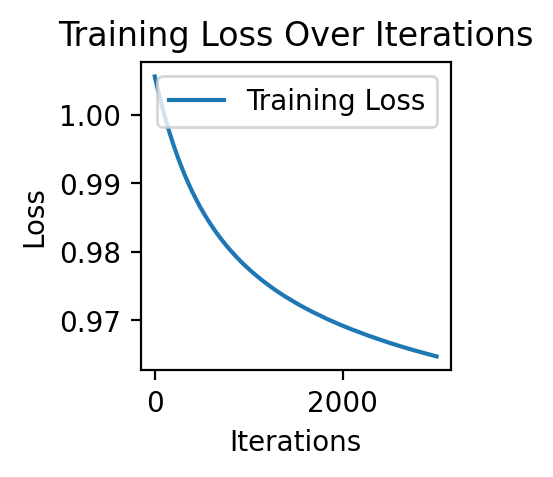

Calibrating to 128 patients
Early stopping after 2345 epochs.
Optimized thetas: tensor([0.5976, 0.2108, 0.1916], grad_fn=<DivBackward0>)


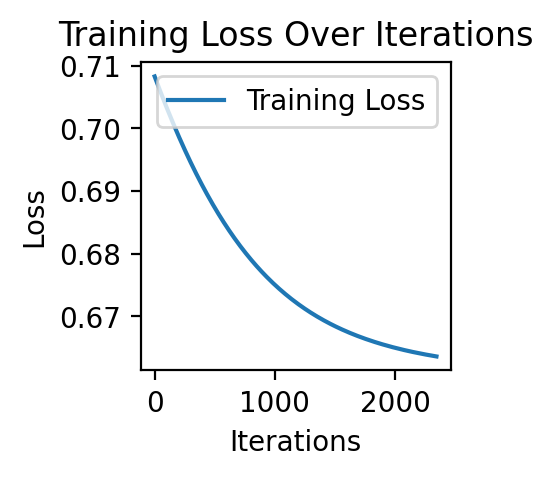


**** RUN 9 ***
Calibrating to 7 patients
Optimized thetas: tensor([0.6842, 0.1579, 0.1579], grad_fn=<DivBackward0>)


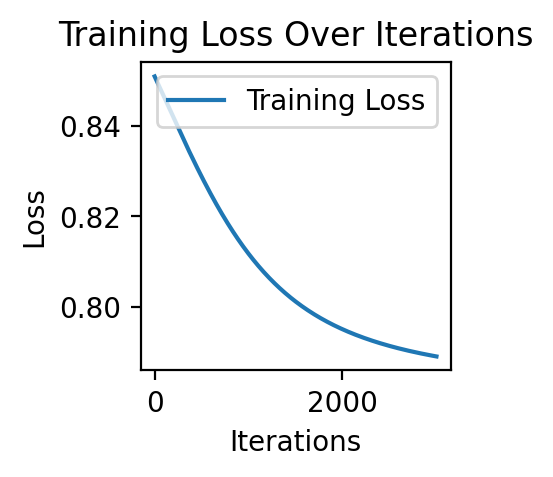

Calibrating to 8 patients
Early stopping after 922 epochs.
Optimized thetas: tensor([0.4659, 0.2295, 0.3046], grad_fn=<DivBackward0>)


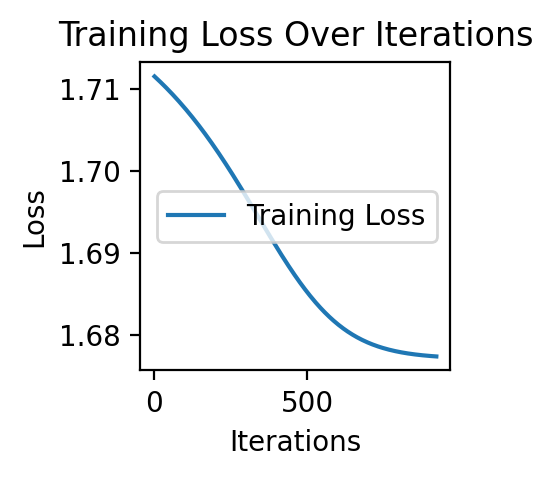

Calibrating to 26 patients
Early stopping after 1917 epochs.
Optimized thetas: tensor([0.5823, 0.2413, 0.1764], grad_fn=<DivBackward0>)


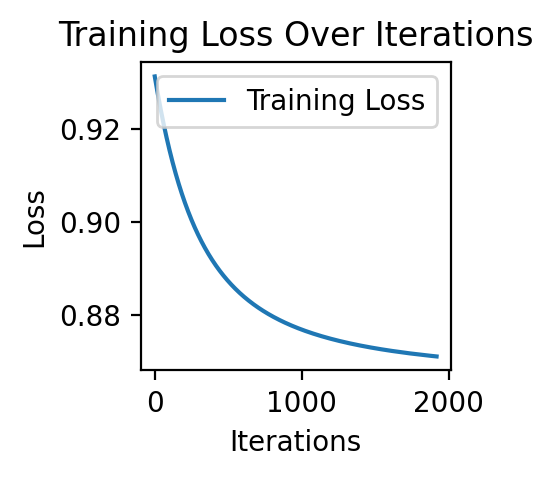

Calibrating to 128 patients
Early stopping after 1982 epochs.
Optimized thetas: tensor([0.5389, 0.2395, 0.2217], grad_fn=<DivBackward0>)


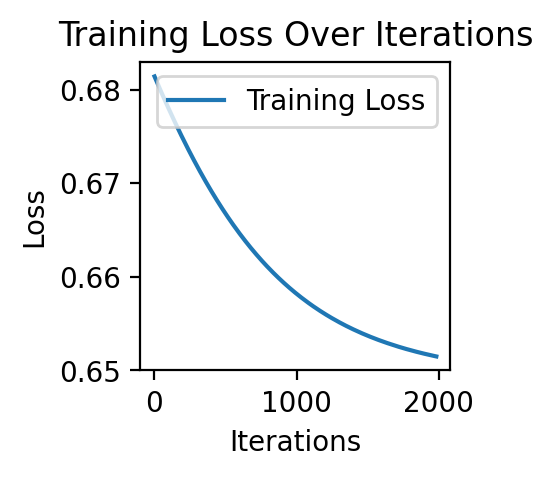


**** RUN 10 ***
Calibrating to 7 patients
Early stopping after 1997 epochs.
Optimized thetas: tensor([0.6129, 0.1936, 0.1936], grad_fn=<DivBackward0>)


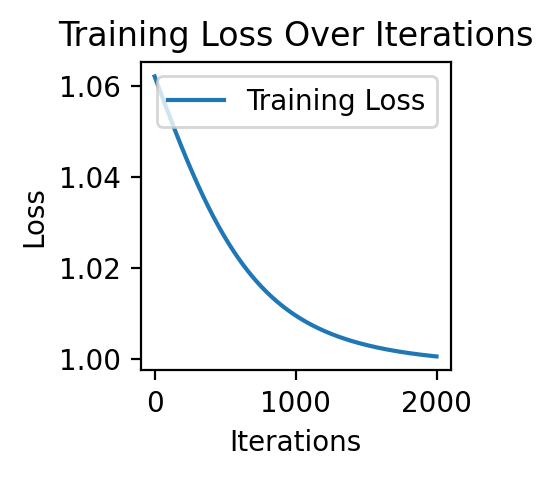

Calibrating to 8 patients
Optimized thetas: tensor([0.6893, 0.2328, 0.0779], grad_fn=<DivBackward0>)


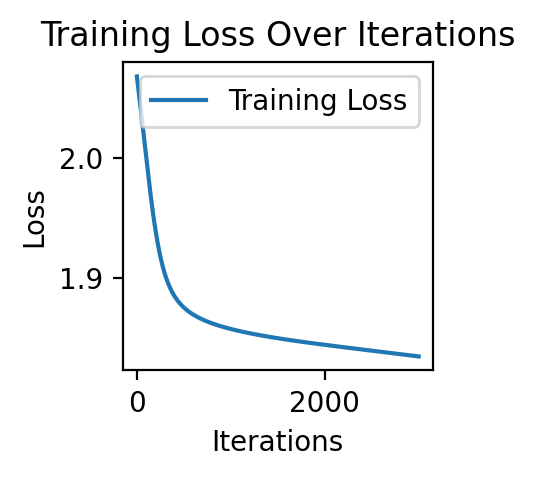

Calibrating to 26 patients
Early stopping after 2712 epochs.
Optimized thetas: tensor([0.6764, 0.1846, 0.1390], grad_fn=<DivBackward0>)


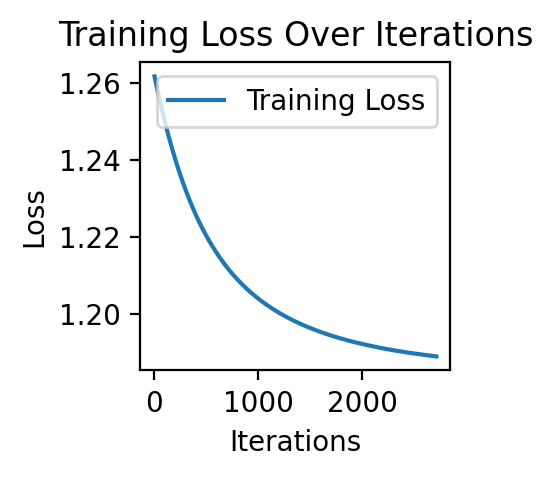

Calibrating to 128 patients
Early stopping after 1978 epochs.
Optimized thetas: tensor([0.5697, 0.2126, 0.2177], grad_fn=<DivBackward0>)


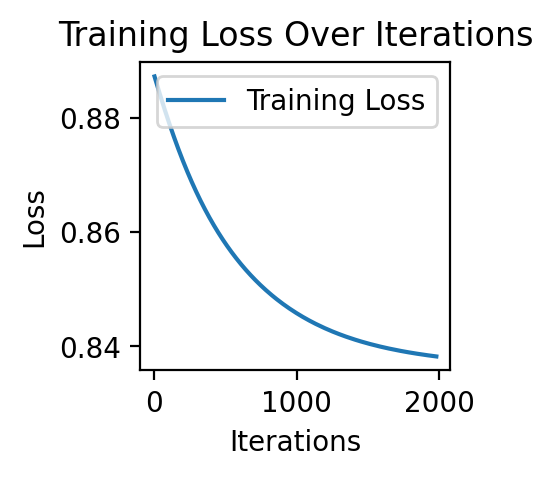


**** RUN 11 ***
Calibrating to 7 patients
Early stopping after 31 epochs.
Optimized thetas: tensor([0.3333, 0.3333, 0.3333], grad_fn=<DivBackward0>)


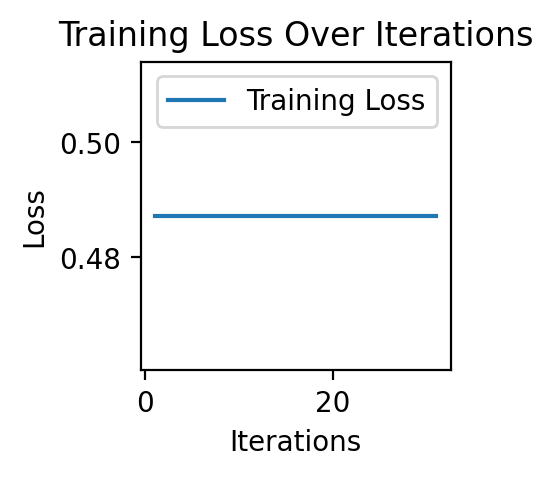

Calibrating to 8 patients
Optimized thetas: tensor([0.5892, 0.3051, 0.1058], grad_fn=<DivBackward0>)


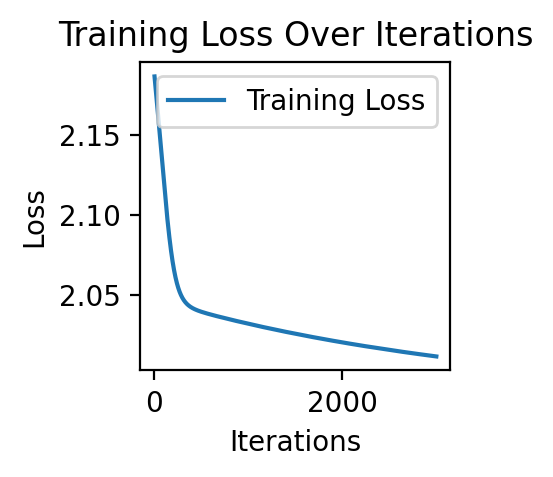

Calibrating to 26 patients
Early stopping after 2175 epochs.
Optimized thetas: tensor([0.6468, 0.1753, 0.1779], grad_fn=<DivBackward0>)


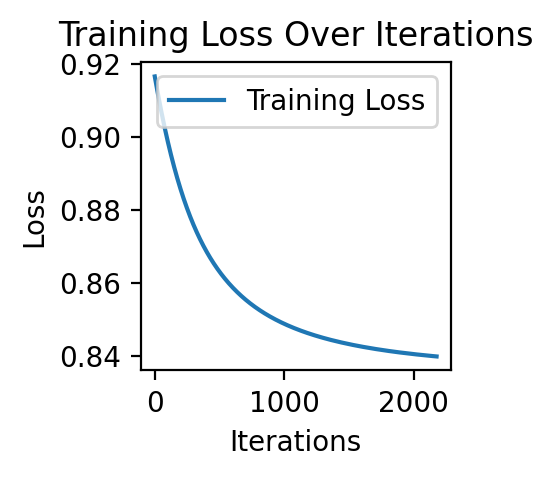

Calibrating to 128 patients
Early stopping after 1878 epochs.
Optimized thetas: tensor([0.5384, 0.2288, 0.2328], grad_fn=<DivBackward0>)


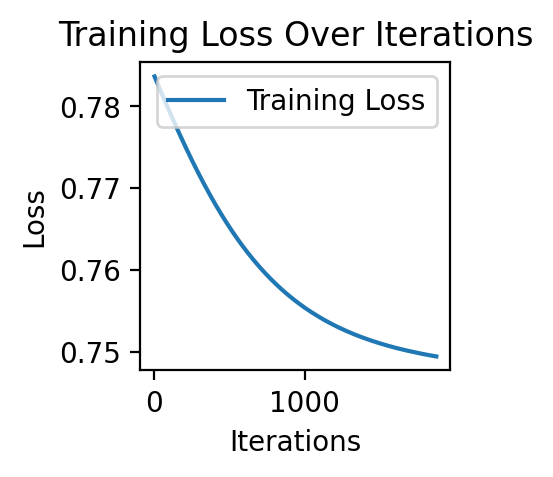


**** RUN 12 ***
Calibrating to 7 patients
Early stopping after 1811 epochs.
Optimized thetas: tensor([0.7269, 0.1366, 0.1366], grad_fn=<DivBackward0>)


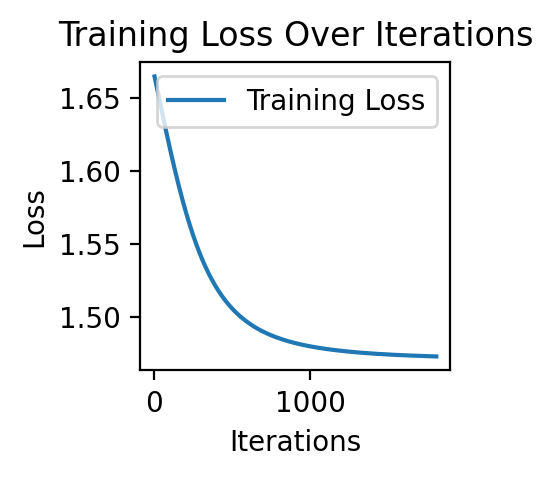

Calibrating to 8 patients
Early stopping after 2061 epochs.
Optimized thetas: tensor([0.6079, 0.2095, 0.1826], grad_fn=<DivBackward0>)


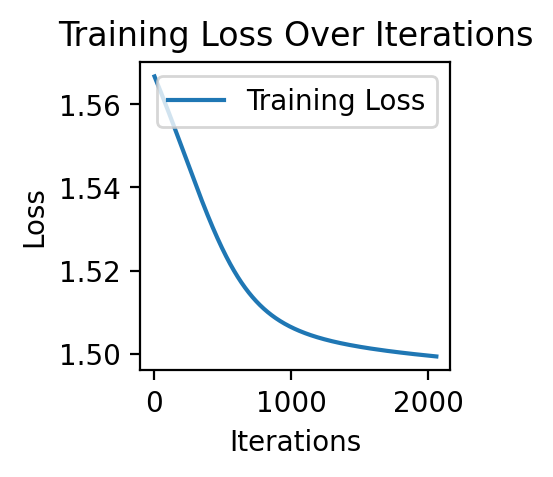

Calibrating to 26 patients
Early stopping after 1154 epochs.
Optimized thetas: tensor([0.4073, 0.3097, 0.2829], grad_fn=<DivBackward0>)


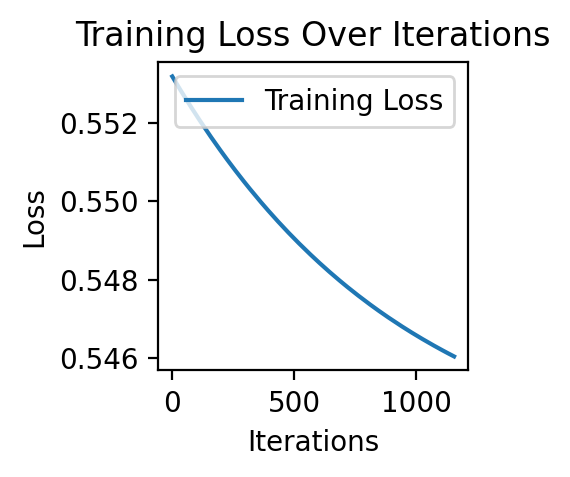

Calibrating to 128 patients
Early stopping after 1874 epochs.
Optimized thetas: tensor([0.5135, 0.2448, 0.2417], grad_fn=<DivBackward0>)


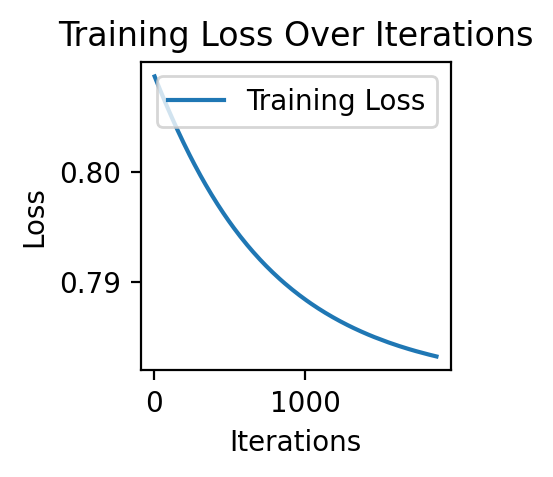


**** RUN 13 ***
Calibrating to 7 patients
Early stopping after 1232 epochs.
Optimized thetas: tensor([0.4797, 0.2602, 0.2602], grad_fn=<DivBackward0>)


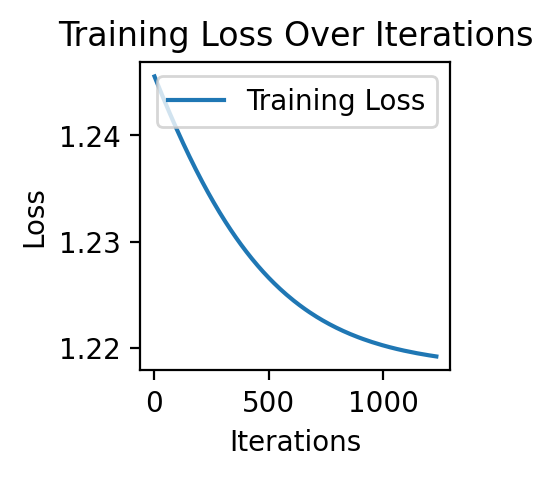

Calibrating to 8 patients
Early stopping after 1957 epochs.
Optimized thetas: tensor([0.6517, 0.1976, 0.1507], grad_fn=<DivBackward0>)


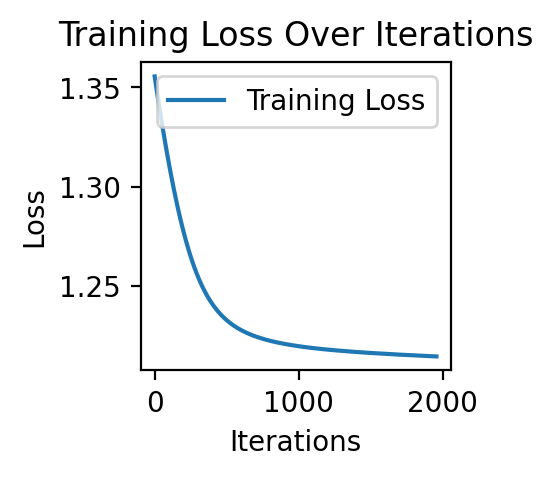

Calibrating to 26 patients
Early stopping after 1595 epochs.
Optimized thetas: tensor([0.6262, 0.1978, 0.1761], grad_fn=<DivBackward0>)


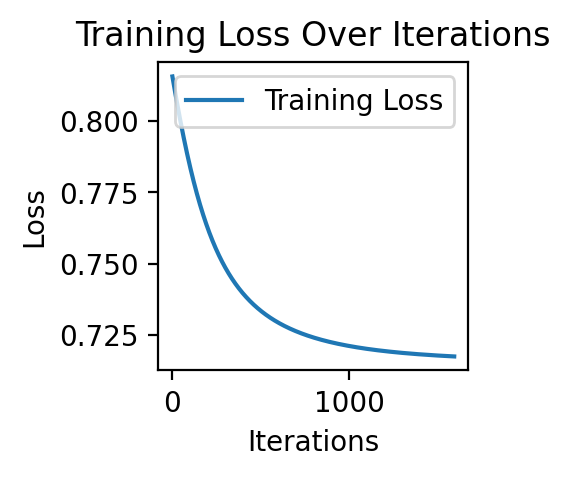

Calibrating to 128 patients
Early stopping after 1749 epochs.
Optimized thetas: tensor([0.4789, 0.2649, 0.2562], grad_fn=<DivBackward0>)


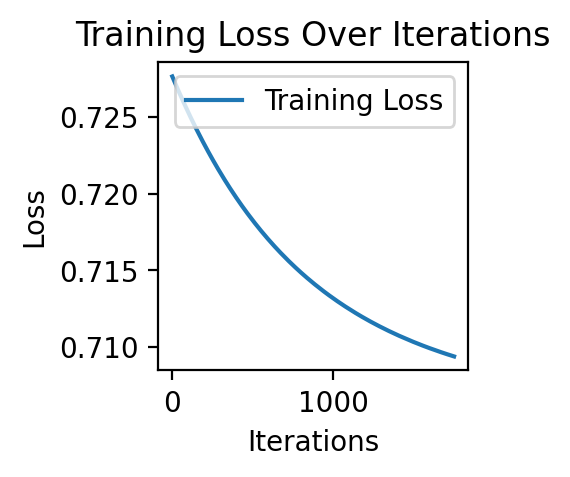


**** RUN 14 ***
Calibrating to 7 patients
Early stopping after 1424 epochs.
Optimized thetas: tensor([0.4619, 0.2690, 0.2690], grad_fn=<DivBackward0>)


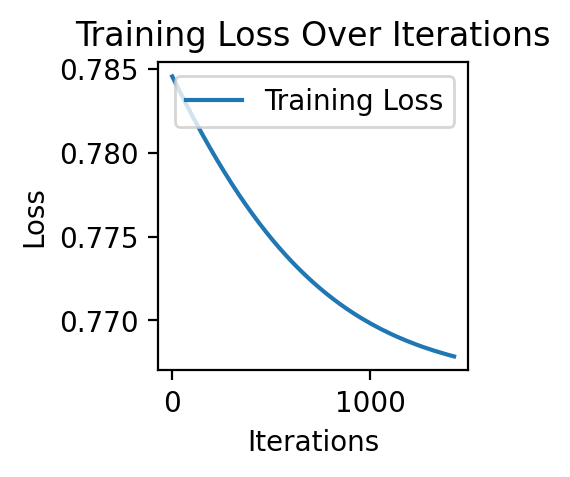

Calibrating to 8 patients
Optimized thetas: tensor([0.8268, 0.0866, 0.0866], grad_fn=<DivBackward0>)


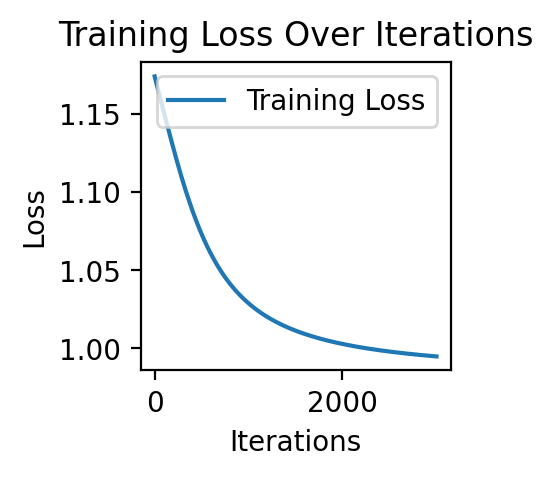

Calibrating to 26 patients
Early stopping after 2588 epochs.
Optimized thetas: tensor([0.6127, 0.2198, 0.1675], grad_fn=<DivBackward0>)


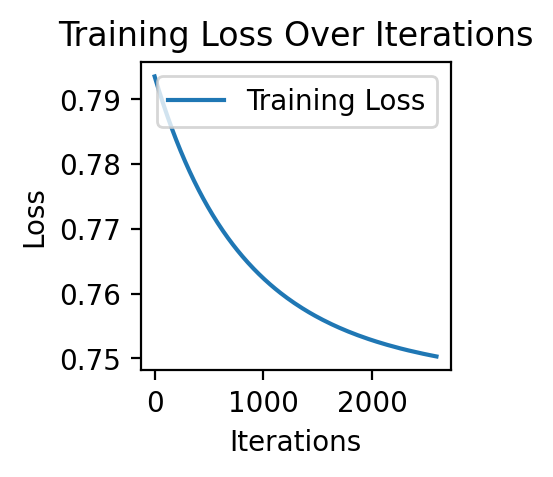

Calibrating to 128 patients


In [ ]:
data = []


# Bootstrap sampling
for i in range(num_bootstrap_samples):
    print(f"\n**** RUN {i+1} ***")
    for dataset in dataset_to_pickle_files:
        matching_files = [x[0] for x in dataset_to_pickle_files[dataset]]
        if len(matching_files) == 0:
            continue
        # Create a bootstrap sample by sampling with replacement
        bootstrap_sample = list(np.random.choice(matching_files, size=len(matching_files), replace=True))
        thetas = eutil.get_max_cross_ent_thetas(pickle_file_list=bootstrap_sample)
        #thetas = convert_thetas_to_alt_metrics(thetas)
        for midx, metric in enumerate(METRICS):
            data.append([dataset, metric, thetas[midx]])

thetas_split_on_same_cohort = pd.DataFrame(data, columns=["dataset", "Parsimony metric", "Fit theta"])
thetas_split_on_same_cohort.to_csv('thetas_split_on_same_cohort.csv') 
thetas_split_on_same_cohort

### How consistent are thetas when calibrating on random samples amongst all cancer type cohorts?

In [ ]:
data = []
dataset_sizes = []
all_matching_files = []
for dataset in dataset_to_pickle_files:
    files = dataset_to_pickle_files[dataset]
    dataset_sizes.append(len(files))
    all_matching_files.extend(files)
print(dataset_sizes, len(all_matching_files))

for i in range(num_bootstrap_samples):
    print(f"\n**** RUN {i+1} ***")
    matching_files = [x[0] for x in all_matching_files]
    if len(matching_files) == 0:
        continue
    # Create a bootstrap sample by sampling with replacement
    bootstrap_sample = list(np.random.choice(matching_files, size=len(matching_files), replace=True))
    thetas = eutil.get_max_cross_ent_thetas(pickle_file_list=bootstrap_sample)
    for midx, metric in enumerate(METRICS):
        data.append([metric, thetas[midx]])

thetas_split_on_random_cohort = pd.DataFrame(data, columns=["Parsimony metric", "Fit theta"])
thetas_split_on_random_cohort.to_csv('thetas_split_on_random_cohort.csv') 

thetas_split_on_random_cohort

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=8.939e-32 stat=2.049e+01
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=1.000e+00 stat=2.716e-07
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=8.939e-32 stat=2.049e+01


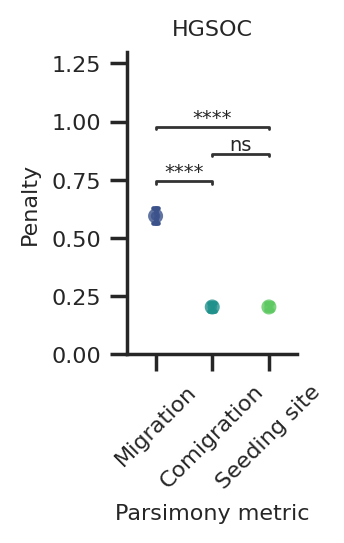

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=1.741e-31 stat=1.927e+01
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=1.300e-02 stat=2.531e+00
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=1.589e-34 stat=2.042e+01


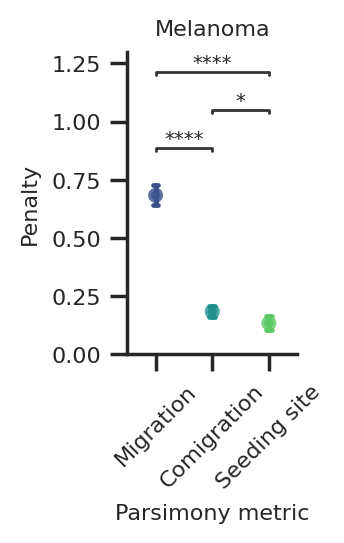

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=3.371e-31 stat=1.808e+01
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=5.148e-05 stat=4.237e+00
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=3.234e-36 stat=2.188e+01


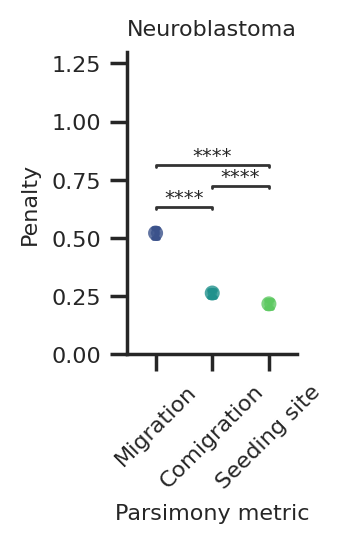

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=2.291e-41 stat=2.822e+01
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=1.158e-01 stat=1.587e+00
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=9.189e-44 stat=2.829e+01


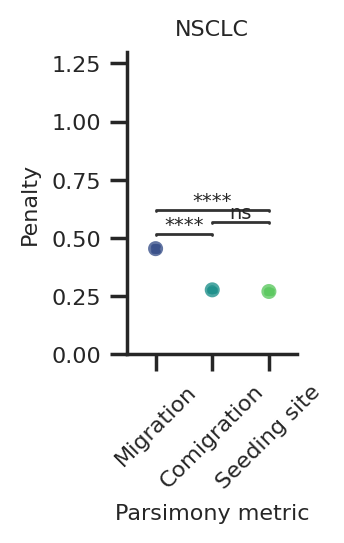

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Migration v.s. Comigration: Welch's t-test independent samples, P_val=1.090e-52 stat=3.870e+01
Comigration v.s. Seeding site: Welch's t-test independent samples, P_val=4.639e-03 stat=2.898e+00
Migration v.s. Seeding site: Welch's t-test independent samples, P_val=6.451e-54 stat=4.099e+01


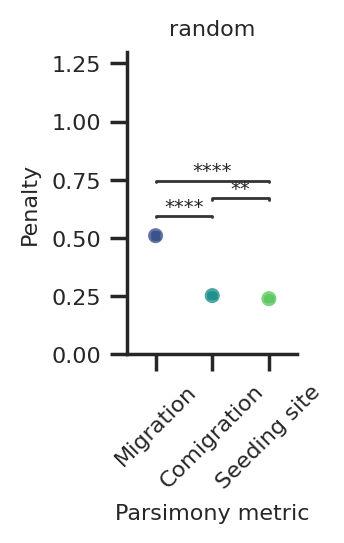

In [2]:
# Load data
thetas_split_on_random_cohort = pd.read_csv('thetas_split_on_random_cohort.csv', index_col=False).drop(columns=['Unnamed: 0']) 
thetas_split_on_same_cohort = pd.read_csv('thetas_split_on_same_cohort.csv', index_col=False).drop(columns=['Unnamed: 0']) 

colors = sns.color_palette("flare")[2:]

def point_plot(df, color, name, with_stats):
   
    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8})

    fig = plt.figure(figsize=(2, 2.5), dpi=200)
    snsfig = sns.pointplot(data=df, x='Parsimony metric', y='Fit theta', markersize=0.5, errwidth=1.7,capsize=0.1, 
                           dodge=True, markers='.', errorbar='sd', palette='viridis')

#     snsfig = sns.violinplot(x='Parsimony metric', y='Fit theta', data=df, 
#                          linewidth=0.7, color=color, alpha=0.5, inner=None)
    
    if with_stats:
        add_stat_annotation(snsfig, data=df, x='Parsimony metric', y="Fit theta",
                            box_pairs=itertools.combinations(METRICS, 2),
                            line_offset=0.17,test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.1, 
                            text_offset=0.00001, verbose=2,  fontsize=7, comparisons_correction=None,linewidth=1.0,
                            )
    if with_stats:
        plt.ylim(0, 1.3) 
    else:
        plt.ylim(0, 1.0)
    plt.ylabel("Penalty")
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    saved_name = "_".join(name.split(" "))
    plt.setp(snsfig.collections, alpha=0.8)
    plt.tight_layout(pad=1.8) 
    plt.xticks(rotation=45)  
    plt.savefig(f"output_plots/{saved_name}_theta_distribution.png", dpi=500)
    plt.title(name, fontsize=8)
    plt.show()
    plt.close()

with_stats = True
for i,dataset in enumerate(dataset_to_pickle_files):
    subset = thetas_split_on_same_cohort[thetas_split_on_same_cohort['dataset']==dataset]
    point_plot(subset, colors[i], dataset, with_stats)

point_plot(thetas_split_on_random_cohort, 'lightseagreen', 'random', with_stats)


### Make one plot per metric with datasets side by side 

    Parsimony metric  Fit theta   dataset
0          Migration      0.596  Combined
1        Comigration      0.209  Combined
2       Seeding site      0.195  Combined
3          Migration      0.477  Combined
4        Comigration      0.269  Combined
..               ...        ...       ...
145      Comigration      0.246  Combined
146     Seeding site      0.240  Combined
147        Migration      0.452  Combined
148      Comigration      0.271  Combined
149     Seeding site      0.277  Combined

[150 rows x 3 columns]
           dataset Parsimony metric  Fit theta
0            HGSOC        Migration      0.333
1            HGSOC      Comigration      0.333
2            HGSOC     Seeding site      0.333
3         Melanoma        Migration      0.907
4         Melanoma      Comigration      0.046
..             ...              ...        ...
595  Neuroblastoma      Comigration      0.275
596  Neuroblastoma     Seeding site      0.175
597          NSCLC        Migration      0.475
59

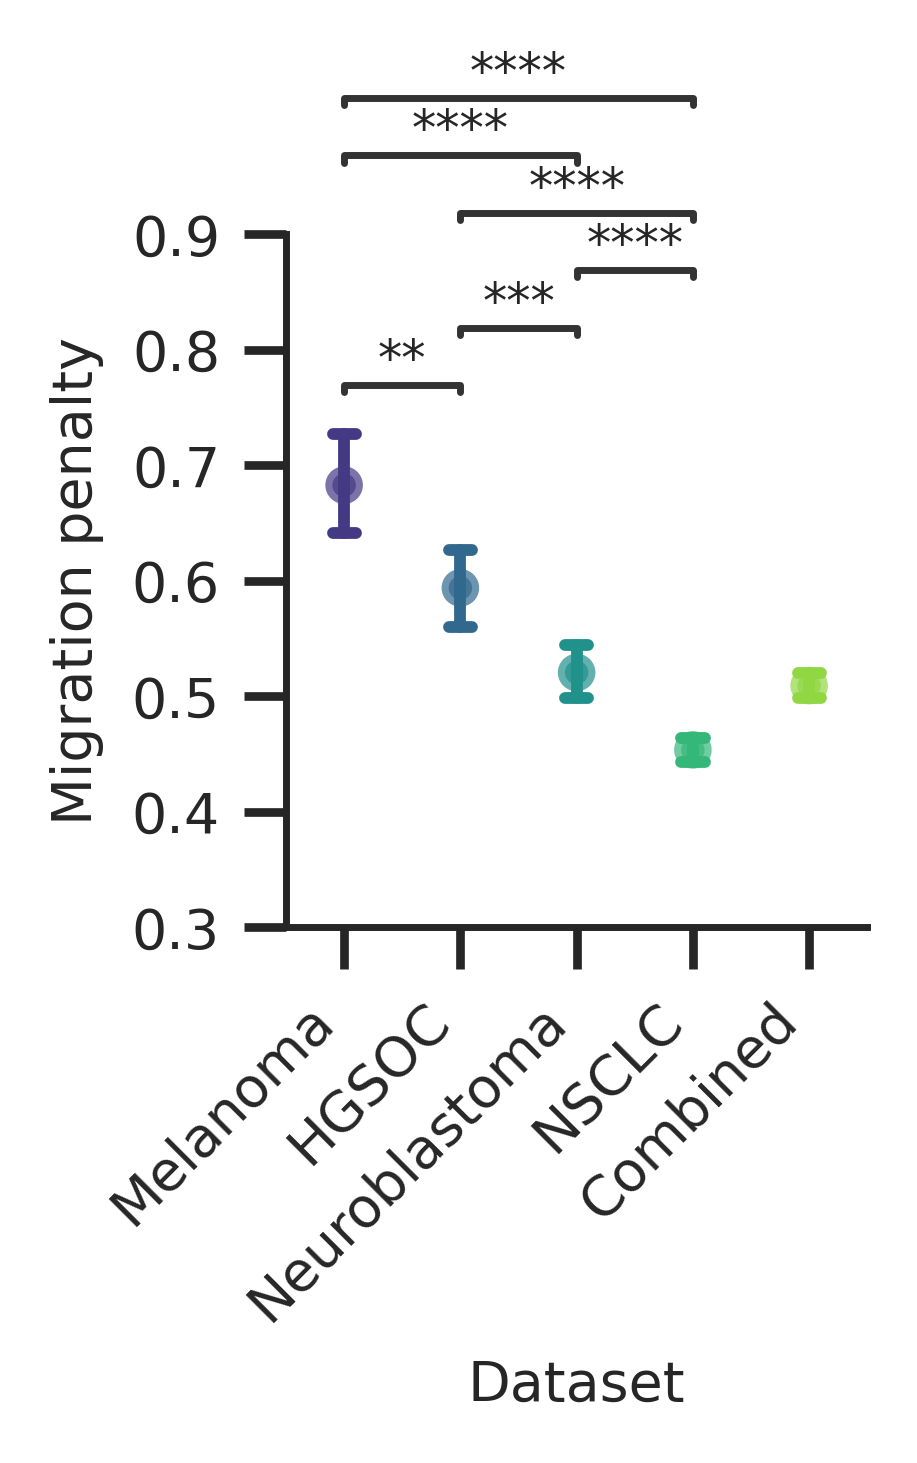

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=2.121e-01 stat=-1.257e+00
HGSOC v.s. Neuroblastoma: Welch's t-test independent samples, P_val=1.664e-06 stat=-5.100e+00
Neuroblastoma v.s. NSCLC: Welch's t-test independent samples, P_val=1.151e-01 stat=-1.598e+00
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=2.429e-11 stat=-8.171e+00
Melanoma v.s. Neuroblastoma: Welch's t-test independent samples, P_val=1.448e-06 stat=-5.198e+00
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=4.041e-09 stat=-7.007e+00


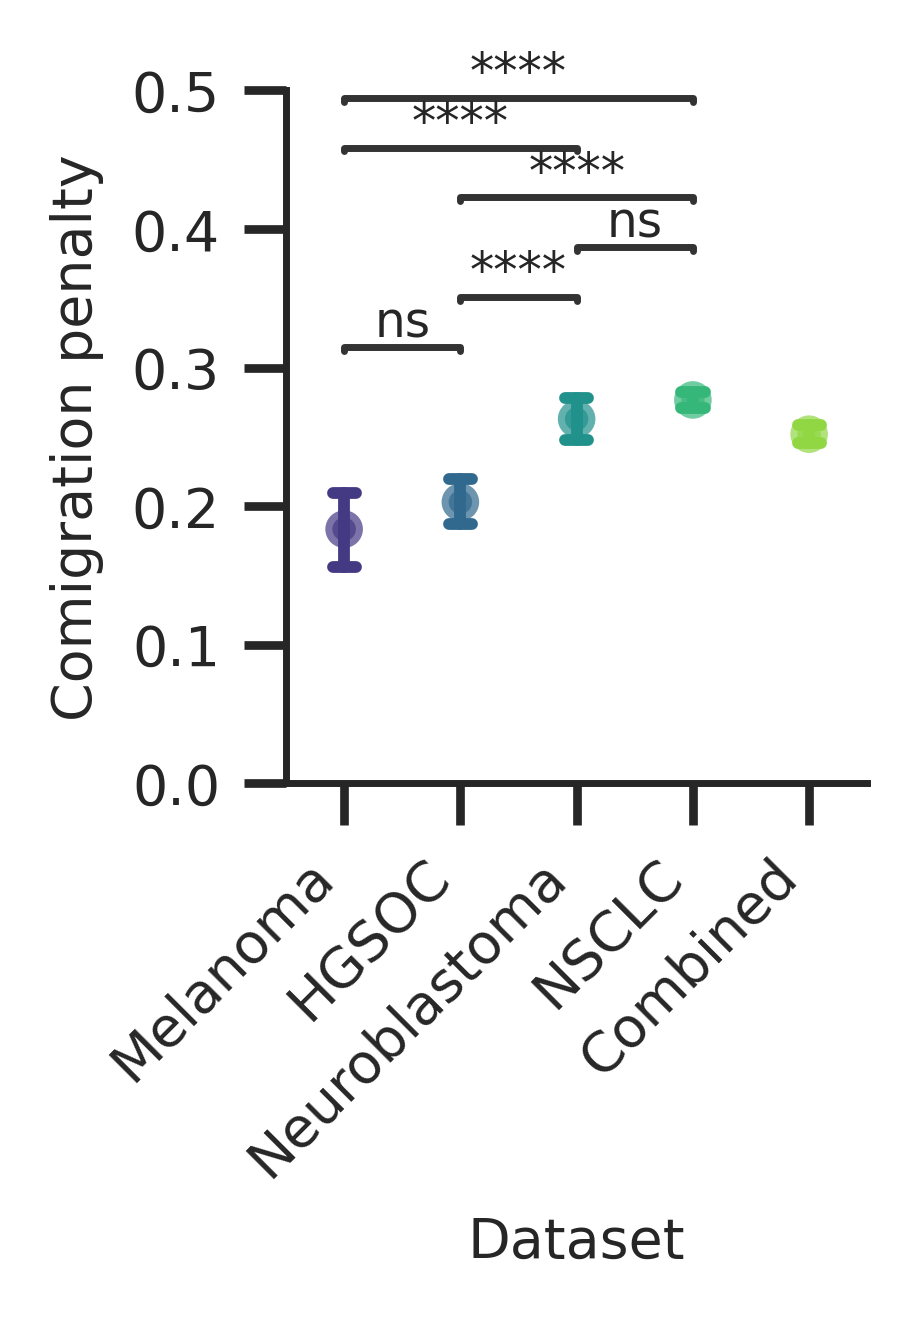

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=1.170e-04 stat=-4.056e+00
HGSOC v.s. Neuroblastoma: Welch's t-test independent samples, P_val=2.423e-01 stat=-1.177e+00
Neuroblastoma v.s. NSCLC: Welch's t-test independent samples, P_val=1.111e-08 stat=-6.496e+00
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=6.687e-10 stat=-7.251e+00
Melanoma v.s. Neuroblastoma: Welch's t-test independent samples, P_val=4.118e-06 stat=-4.984e+00
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=3.049e-12 stat=-8.939e+00


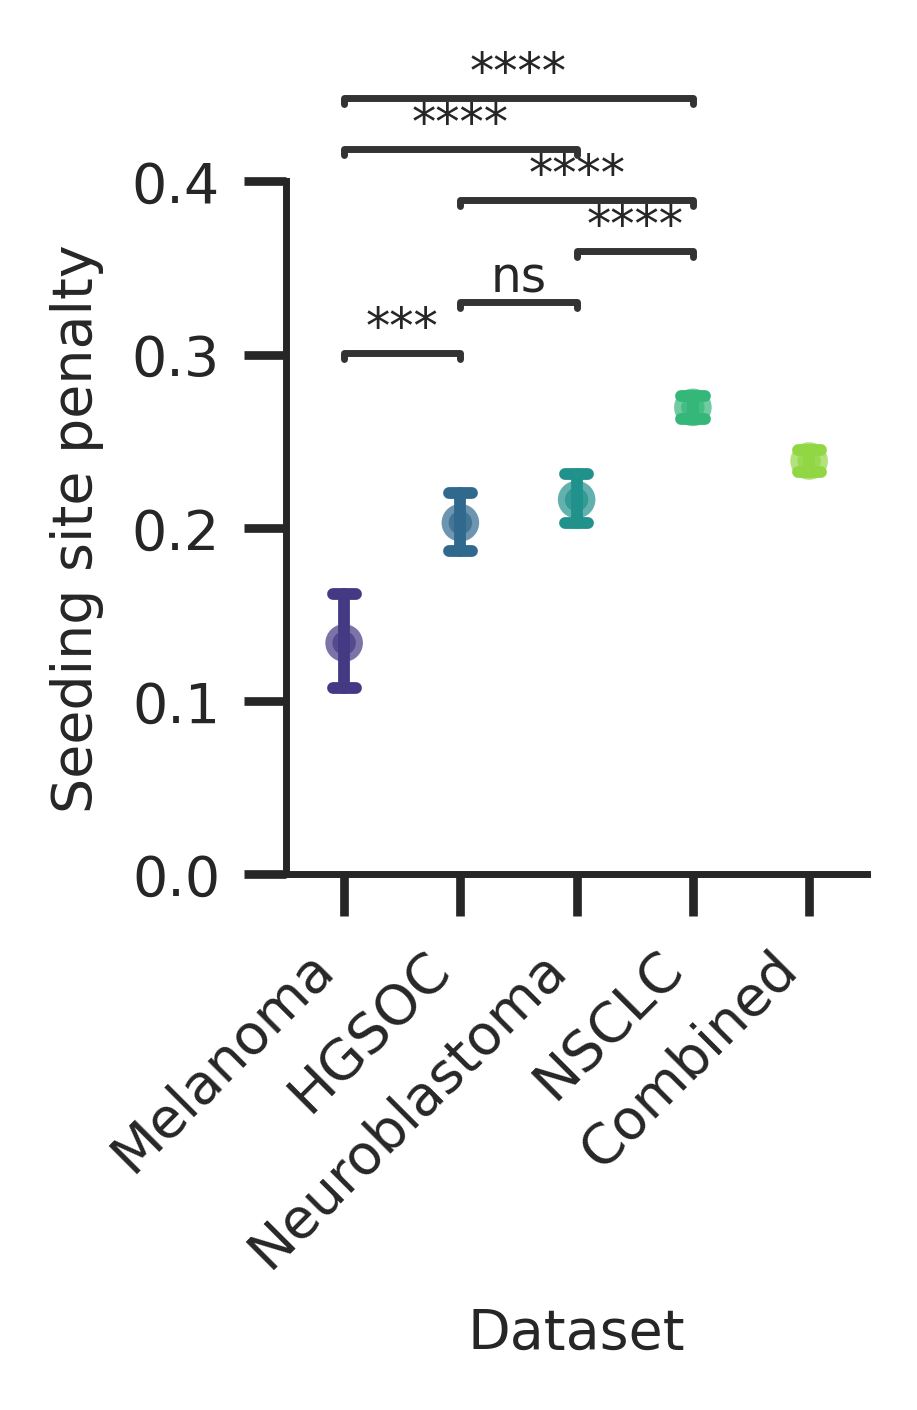

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Melanoma v.s. HGSOC: Welch's t-test independent samples, P_val=5.066e-02 stat=1.979e+00
HGSOC v.s. Neuroblastoma: Welch's t-test independent samples, P_val=9.998e-05 stat=4.070e+00
Neuroblastoma v.s. NSCLC: Welch's t-test independent samples, P_val=1.109e-03 stat=3.405e+00
HGSOC v.s. NSCLC: Welch's t-test independent samples, P_val=3.410e-10 stat=7.491e+00
Melanoma v.s. Neuroblastoma: Welch's t-test independent samples, P_val=3.260e-08 stat=6.066e+00
Melanoma v.s. NSCLC: Welch's t-test independent samples, P_val=1.563e-13 stat=9.524e+00


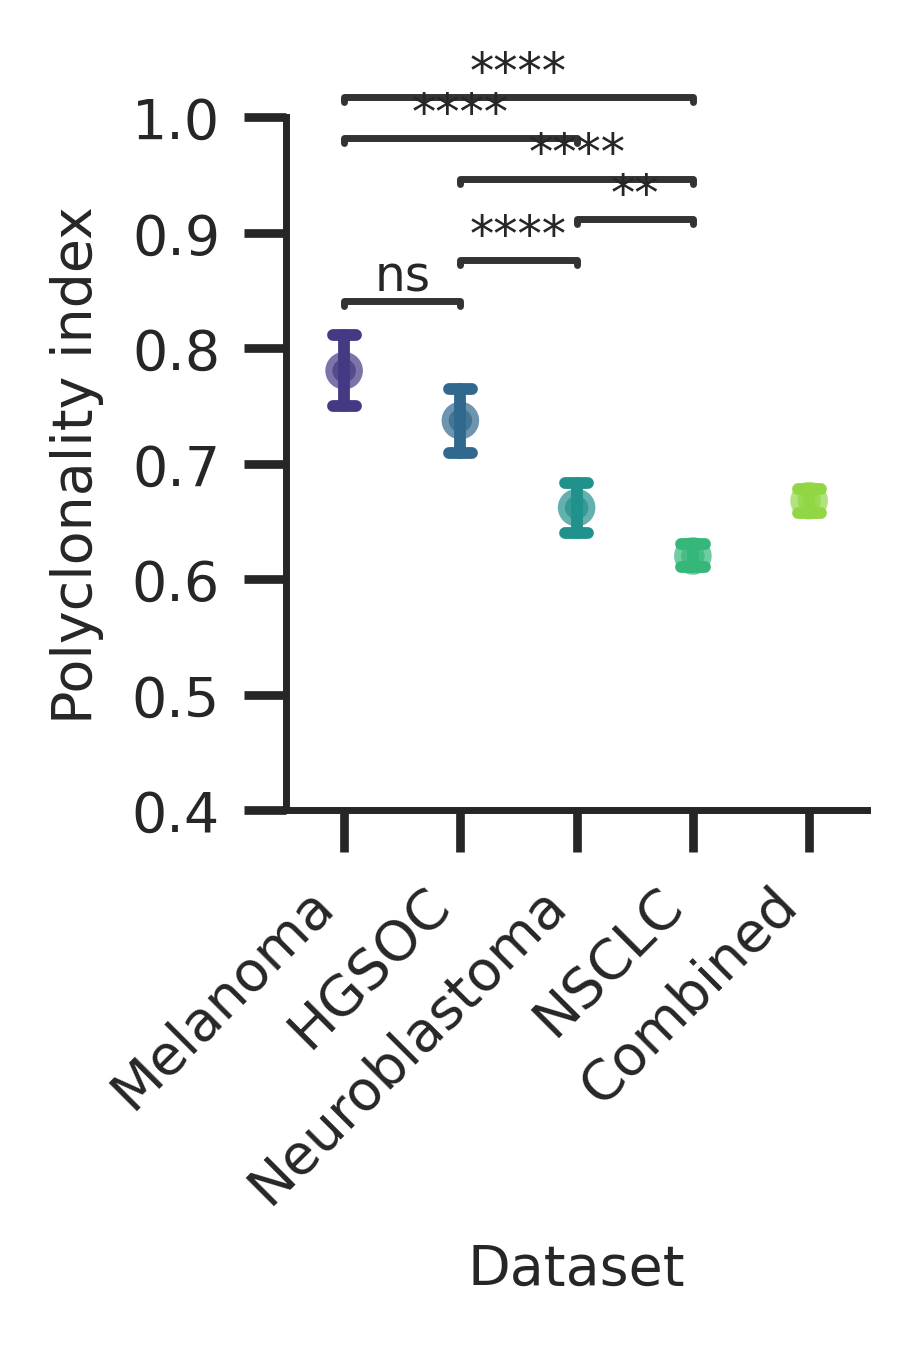

In [3]:
from matplotlib.colors import to_rgb
from statannot import add_stat_annotation

dataset_order = ["Melanoma", "HGSOC", "Neuroblastoma", "NSCLC", "Combined"]
def plot_all_metrics(df, metric, with_stats, ylim, shape=(1.5,1.5), colors=None):
    if colors == None:
        colors = sns.color_palette("flare")[2:6]
        colors.append((to_rgb("lightseagreen")))

    sns.set(style='ticks', font="Arial", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
    subset = df[df['Parsimony metric']==metric]
    if with_stats:
        shape = (shape[0], shape[1]+0.3)
    fig = plt.figure(figsize=(shape[0], shape[1]), dpi=500)

    snsfig = sns.pointplot(data=subset, x='dataset', y='Fit theta', s=5, errwidth=1.7, order=dataset_order,
                           dodge=True, markers='.', errorbar='se', palette='viridis', capsize=0.2)

#     snsfig = sns.violinplot(x='dataset', y='Fit theta', data=subset, palette=colors,
#                          linewidth=0.7, alpha=0.5, inner=None )

    groups = list(subset['dataset'].unique())
    
    # Plot the medians
#     medians = [np.median(subset[subset['dataset']==dataset]['Fit theta']) for dataset in set(groups)]
#     plt.setp(snsfig.collections, alpha=.3)
#     plt.scatter(x=range(len(medians)),y=medians,c="k",s=5.0, )
    
    if with_stats:
        if "Combined" in groups: groups.remove("Combined")

        line_offset = 0.17 if metric == 'Comigration' else 0.07
        add_stat_annotation(snsfig, data=subset, x='dataset', y="Fit theta",
                            box_pairs=itertools.combinations(groups, 2),order=dataset_order, line_offset=line_offset,
                            test='t-test_welch', text_format='star', loc='outside', line_offset_to_box=0.1, 
                            text_offset=0.00001, verbose=2,  fontsize=7, comparisons_correction=None,linewidth=1.0,
                            )
        plt.ylim(ylim[0]-0.1, ylim[1]+0.1) 
    else:
        plt.ylim(ylim[0], ylim[1]) 
            
    snsfig.set_xticklabels(snsfig.get_xticklabels(), rotation=45, horizontalalignment='right')
    
    plt.xlabel("Dataset", fontsize=8)
    ylabel = f"{metric} penalty" if "index" not in metric else metric
    plt.ylabel(ylabel, fontsize=8)
    snsfig.spines['top'].set_visible(False)
    snsfig.spines['right'].set_visible(False)
    saved_name = "_".join(metric.split(" "))
    plt.setp(snsfig.collections, alpha=0.7)
    #plt.tight_layout() 
    plt.savefig(f"output_plots/{saved_name}_theta_distribution_stat.png", dpi=500,  bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()
    
thetas_split_on_random_cohort['dataset'] = "Combined"
print(thetas_split_on_random_cohort)
print(thetas_split_on_same_cohort)
combined_df = pd.concat([thetas_split_on_same_cohort, thetas_split_on_random_cohort], axis=0)
combined_df = combined_df[combined_df['dataset']!='Breast Cancer'].reset_index(drop=True)

# This is to plot the alternative metrics (Effective migration #, polyclonality index)
import math
group_size = 3
tolerance = 1e-4
rows_to_add = []
for _, group in combined_df.groupby(combined_df.index // group_size):
    assert(math.isclose(group['Fit theta'].sum(),1.0, rel_tol=tolerance, abs_tol=tolerance))
    dataset = group['dataset'].unique().item()

    mig = float(group[group['Parsimony metric']=="Migration"]["Fit theta"].item())
    comig = float(group[group['Parsimony metric']=="Comigration"]["Fit theta"].item())
    ss = float(group[group['Parsimony metric']=="Seeding site"]["Fit theta"].item())
    rows_to_add.append([dataset,  "Migration # index", 1-(mig)])
    rows_to_add.append([dataset,  "Polyclonality index", 1-(comig/(mig+comig))])
    rows_to_add.append([dataset,  "Comigration # index", 1-(comig)])
    rows_to_add.append([dataset,  "Seeding site index", 1-ss])

combined_df = pd.concat([combined_df, pd.DataFrame(rows_to_add, columns=combined_df.columns)], axis=0)

with_stats = True
plot_all_metrics(combined_df, 'Migration', with_stats, (0.4,0.8))
plot_all_metrics(combined_df, 'Comigration', with_stats,(0.1,0.4))
plot_all_metrics(combined_df, "Seeding site", with_stats, (0.1,0.3))
plot_all_metrics(combined_df, 'Polyclonality index', with_stats, (0.5,0.9))



### How consistent are thetas across NSCLC subtypes?

In [260]:
# Split NSCLC lung cancer patients into their subtype (LUAD and LUSC)
import pyreadr
tracerx_patient_info = pyreadr.read_r(os.path.join('/data/morrisq/divyak/data/tracerx_nsclc_2023/20221109_TRACERx421_all_patient_df.rds'))[None]
tracerx_patient_info['histology_multi_full_genomically.confirmed'].value_counts()

import re
nsclc_subtype_to_pickle_files = {"LUSC":[], "LUAD":[]}
pattern = re.compile(r'CRUK[^_]+')
tracerx_pids = [pattern.search(fn[0]).group() for fn in dataset_to_pickle_files['NSCLC']]
print(len(tracerx_pids))
for pid,fn in zip(tracerx_pids, dataset_to_pickle_files['NSCLC']):
    subtype = tracerx_patient_info[tracerx_patient_info['cruk_id']==pid]['histology_multi_full_genomically.confirmed'].item()
    subtype = "LUAD" if "LUAD" in subtype else subtype
    if subtype == "Other":
        print("Not LUAD or LUSC subtype", pid)
        continue
    nsclc_subtype_to_pickle_files[subtype].append((fn[0], fn[1])) 
num_lusc = len(nsclc_subtype_to_pickle_files["LUSC"])
num_luad = len(nsclc_subtype_to_pickle_files["LUAD"])
print(f"LUSC: {num_lusc} patients, LUAD: {num_luad} patients")
    

50
Not LUAD or LUSC subtype CRUK0702
Not LUAD or LUSC subtype CRUK0325
Not LUAD or LUSC subtype CRUK0557
Not LUAD or LUSC subtype CRUK0587
Not LUAD or LUSC subtype CRUK0484
Not LUAD or LUSC subtype CRUK0698
Not LUAD or LUSC subtype CRUK0013
Not LUAD or LUSC subtype CRUK0245
LUSC: 16 patients, LUAD: 26 patients


In [261]:
# Fit thetas to bootstrap samples within the same subtype
data = []
num_bootstrap_samples = 50

# Bootstrap sampling
for i in range(num_bootstrap_samples):
    print(f"\n**** RUN {i+1} ***")
    for subtype in nsclc_subtype_to_pickle_files:
        matching_files = [x[0] for x in nsclc_subtype_to_pickle_files[subtype]]
        if len(matching_files) == 0:
            continue
        # Create a bootstrap sample by sampling with replacement
        bootstrap_sample = list(np.random.choice(matching_files, size=len(matching_files), replace=True))
        thetas = eutil.get_max_cross_ent_thetas(pickle_file_list=bootstrap_sample)
        for midx, metric in enumerate(METRICS):
            data.append([subtype, metric, thetas[midx]])

thetas_split_on_same_cohort = pd.DataFrame(data, columns=["dataset", "Parsimony metric", "Fit theta"])
thetas_split_on_same_cohort


**** RUN 1 ***
Calibrating to 16 patients



KeyboardInterrupt



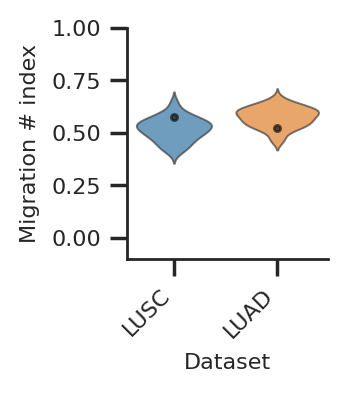

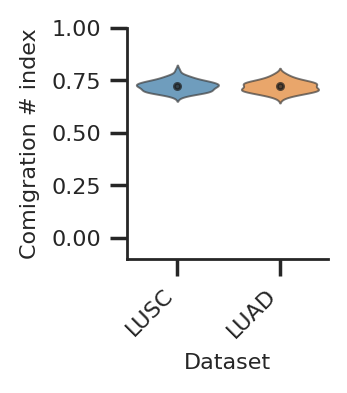

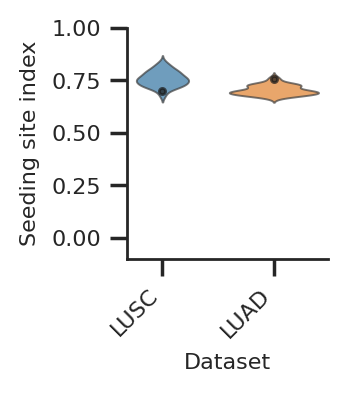

In [264]:
rows_to_add = []
for _, group in thetas_split_on_same_cohort.groupby(thetas_split_on_same_cohort.index // group_size):
    assert(math.isclose(group['Fit theta'].sum(),1.0, rel_tol=tolerance, abs_tol=tolerance))
    dataset = group['dataset'].unique().item()

    mig = float(group[group['Parsimony metric']=="Migration"]["Fit theta"].item())
    comig = float(group[group['Parsimony metric']=="Comigration"]["Fit theta"].item())
    ss = float(group[group['Parsimony metric']=="Seeding site"]["Fit theta"].item())
    rows_to_add.append([dataset,  "Migration # index", 1-(mig)])
    rows_to_add.append([dataset,  "Comigration # index", 1-(comig)])
    rows_to_add.append([dataset,  "Seeding site index", 1-ss])

full_df = pd.concat([thetas_split_on_same_cohort, pd.DataFrame(rows_to_add, columns=thetas_split_on_same_cohort.columns)], axis=0)

plot_all_metrics(full_df, "Migration # index", False, shape=(2,2.3), name="nsclc_subtype", colors=['tab:blue', 'tab:orange'])
plot_all_metrics(full_df, "Comigration # index", False, shape=(2,2.3), name="nsclc_subtype", colors=['tab:blue', 'tab:orange'])
plot_all_metrics(full_df, "Seeding site index", False, shape=(2,2.3), name="nsclc_subtype", colors=['tab:blue', 'tab:orange'])


### Histogram of the number of metastases each patient has (in all cancer cohorts)

In [438]:
# Reload all patient data (not excluding patients with <2 mets)
DATASET_NAMES = ["Breast", "HGSOC", "Melanoma", "Neuroblastoma", "NSCLC"]
CALIBRATE_DIRS = [os.path.join(REPO_DIR,"data/hoadley_breast_cancer_2016/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/mcpherson_ovarian_2016/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/sanborn_melanoma_2015/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/gundem_neuroblastoma_2023/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/tracerx_nsclc/metient_outputs/pyclone_clustered_conipher_trees_02202024_softer_wm/calibrate")]

num_mets = []
dataset_to_all_pickle_files = {dataset:[] for dataset in DATASET_NAMES}
for dataset_name, calibrate_dir in zip(DATASET_NAMES, CALIBRATE_DIRS):
    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    for fn in matching_files:
        with gzip.open(fn, 'rb') as f:
            pkl = pickle.load(f)
            num_sites = len(pkl[OUT_SITES_KEY])
            loss_dicts = pkl[OUT_LOSS_DICT_KEY]
            dataset_to_all_pickle_files[dataset_name].append((fn, num_sites))
            
# Do the same with nsclc patients for each nsclc subtype
nsclc_subtype_to_all_pickle_files = {"LUSC":[], "LUAD":[]}
pattern = re.compile(r'CRUK[^_]+')
tracerx_pids = [pattern.search(fn[0]).group() for fn in dataset_to_all_pickle_files['NSCLC']]
print(len(tracerx_pids))
for pid,fn in zip(tracerx_pids, dataset_to_all_pickle_files['NSCLC']):
    subtype = tracerx_patient_info[tracerx_patient_info['cruk_id']==pid]['histology_multi_full_genomically.confirmed'].item()
    subtype = "LUAD" if "LUAD" in subtype else subtype
    if subtype == "Other":
        print("Not LUAD or LUSC subtype", pid)
        continue
    nsclc_subtype_to_all_pickle_files[subtype].append((fn[0], fn[1])) 

128
Not LUAD or LUSC subtype CRUK0702
Not LUAD or LUSC subtype CRUK0514
Not LUAD or LUSC subtype CRUK0325
Not LUAD or LUSC subtype CRUK0718
Not LUAD or LUSC subtype CRUK0422
Not LUAD or LUSC subtype CRUK0596
Not LUAD or LUSC subtype CRUK0476
Not LUAD or LUSC subtype CRUK0719
Not LUAD or LUSC subtype CRUK0100
Not LUAD or LUSC subtype CRUK0557
Not LUAD or LUSC subtype CRUK0099
Not LUAD or LUSC subtype CRUK0587
Not LUAD or LUSC subtype CRUK0524
Not LUAD or LUSC subtype CRUK0484
Not LUAD or LUSC subtype CRUK0769
Not LUAD or LUSC subtype CRUK0097
Not LUAD or LUSC subtype CRUK0698
Not LUAD or LUSC subtype CRUK0640
Not LUAD or LUSC subtype CRUK0013
Not LUAD or LUSC subtype CRUK0598
Not LUAD or LUSC subtype CRUK0245


In [439]:
def plot_hist(df, hue, bin_edges, colors, shape=(3.2,2)):
    sns.set(style='ticks', rc={'axes.labelsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.0})
    fig = plt.figure(figsize=(shape[0],shape[1]), dpi=500)
    
    print(bin_edges)
    ax = sns.histplot(df, hue=hue, x="Number of metastases", kde=False,  alpha=0.6, palette=colors, 
                      bins=bin_edges,legend=False, multiple='dodge', shrink=0.85, stat="count")
    ax.set_xlim(math.floor(bin_edges[0]), math.ceil(bin_edges[-1]))
    plt.xticks(ticks=[x for x in range(math.floor(bin_edges[0]), math.ceil(bin_edges[-1])+1)])
    plt.xlabel('Number of metastases')
    plt.ylabel('Number of patients')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.setp(ax.collections, alpha=0.7)
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
    plt.tight_layout(pad=1.6) 
    # saved_name = name + "_" + "_".join(metric.split(" "))
    # plt.savefig(f"output_plots/{saved_name}_theta_distribution_stat.png", dpi=300)
    plt.show()
    plt.close()
    

[3, 3, 2, 3, 4, 5, 3, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 5, 2, 2, 3, 2, 2, 4]
[2, 4, 3, 6, 2, 4, 2, 2, 3, 3, 5, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 6, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 2, 4, 6, 3, 2, 5, 2, 5, 2, 2, 3, 2, 3, 3, 6, 2, 2, 4, 2, 3, 2, 3, 2, 2]
[0.5 1.5 2.5 3.5 4.5 5.5]


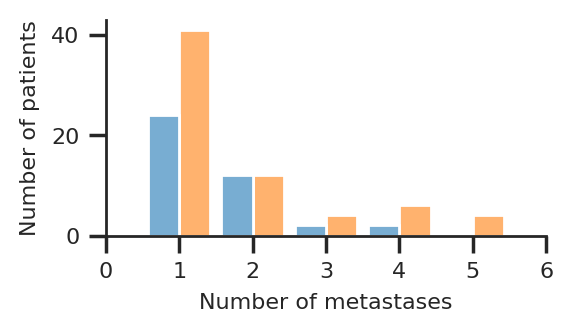

In [440]:
colors = ["tab:blue", "tab:orange"]
lusc_met_counts = [x[1] for x in nsclc_subtype_to_all_pickle_files['LUSC']]
luad_met_counts = [x[1] for x in nsclc_subtype_to_all_pickle_files['LUAD']]
print(lusc_met_counts)
print(luad_met_counts)
data = []
for name, counts in zip(["LUSC", "LUAD"], [lusc_met_counts, luad_met_counts]):
    for count in counts:
        data.append([name, count-1])
df = pd.DataFrame(data, columns=["Subtype", "Number of metastases"])
bin_edges = np.arange(min(min(lusc_met_counts), min(luad_met_counts))-1.5, max(max(lusc_met_counts), max(luad_met_counts)), 1)
plot_hist(df, "Subtype", bin_edges, colors)


Neuroblastoma 17
    Cancer type  Number of metastases
0        Breast                     4
1        Breast                     5
2         HGSOC                     2
3         HGSOC                     2
4         HGSOC                     2
..          ...                   ...
165       NSCLC                     2
166       NSCLC                     1
167       NSCLC                     3
168       NSCLC                     1
169       NSCLC                     1

[170 rows x 2 columns]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


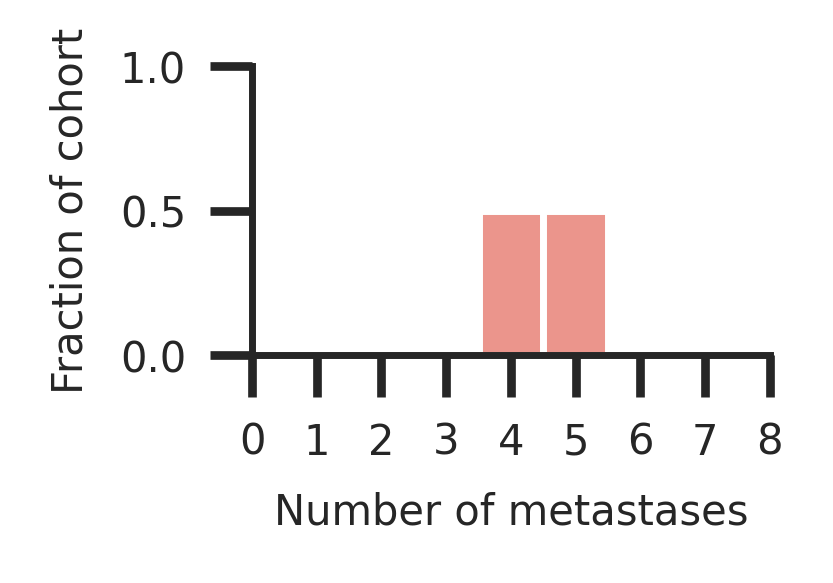

[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


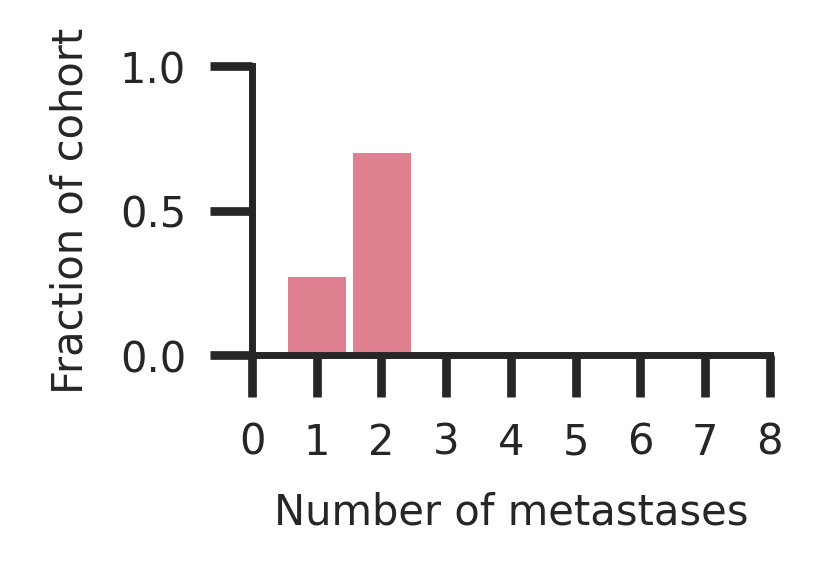

[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


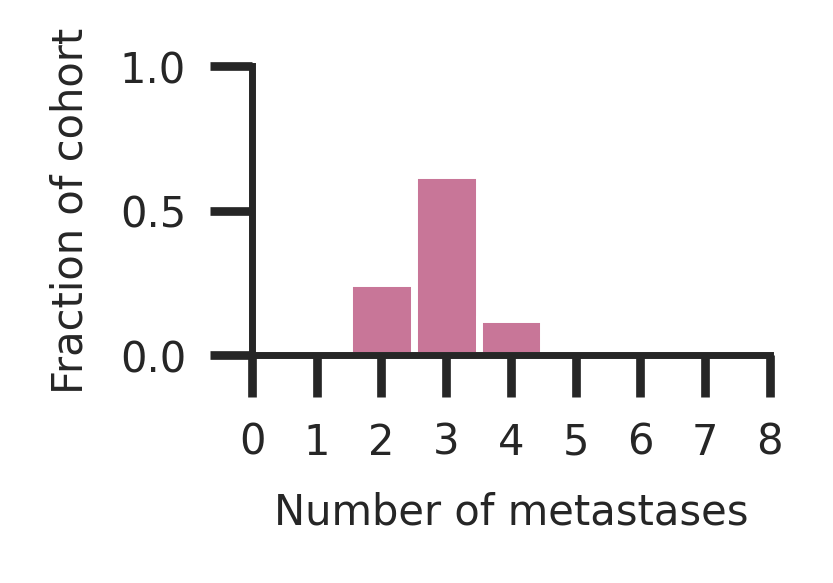

[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


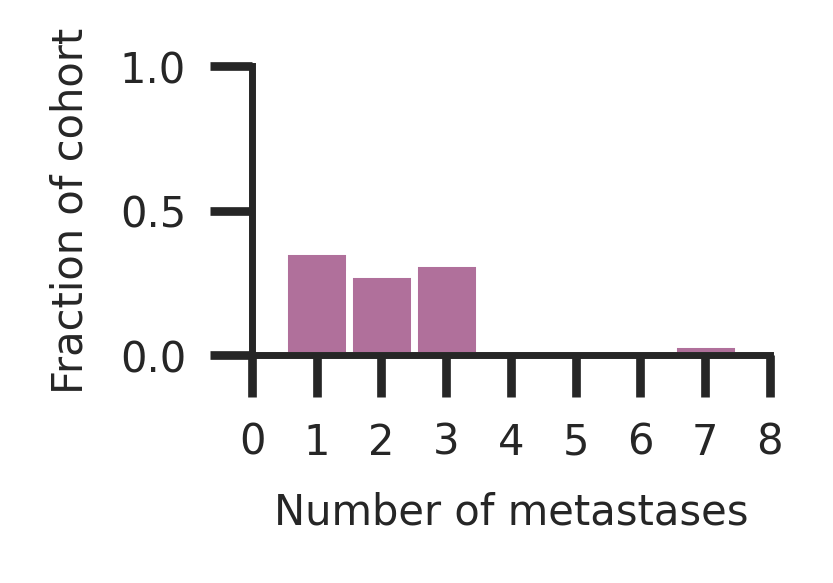

[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


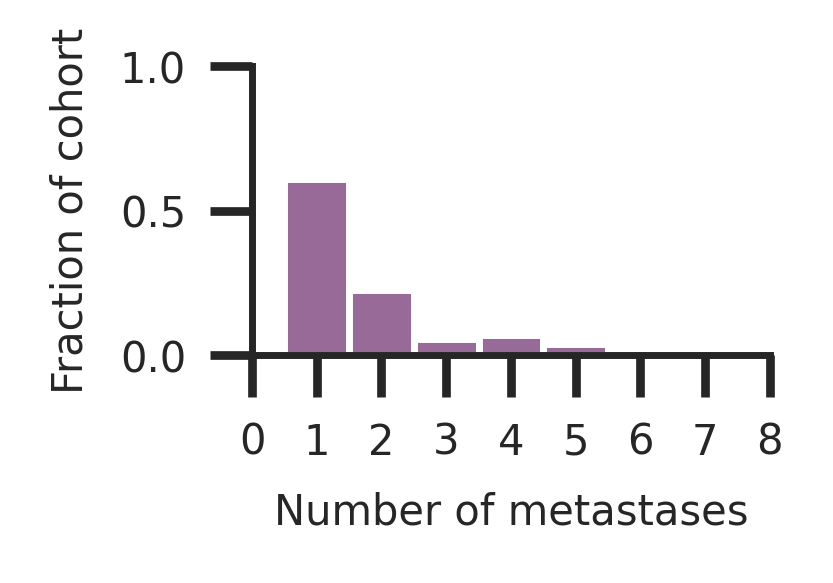

In [468]:
data = []
for dataset in dataset_to_all_pickle_files:
    fns = dataset_to_all_pickle_files[dataset]
    for fn in fns:
        if fn[1] < 9:
            data.append([dataset,fn[1]-1])
        else:
            print(dataset, fn[1])
df = pd.DataFrame(data, columns=["Cancer type", "Number of metastases"])
print(df)  
for dataset,color in zip(DATASET_NAMES, sns.color_palette("flare")[1:6]):
    sns.set(style='ticks', rc={'axes.labelsize': 6, 'xtick.labelsize': 6, 'ytick.labelsize': 6, 'axes.linewidth': 1.0})
    fig = plt.figure(figsize=(2,1.5), dpi=500)
    bin_edges = np.arange(0.5, 10.5, 1)
    
    print(bin_edges)

    ax = sns.histplot(data=df[df['Cancer type']==dataset], x='Number of metastases', legend=False,
                     stat="probability", hue='Cancer type', alpha=0.7, palette=[color], bins=bin_edges,
                     )
    ax.set_xlim(0,8)
    ax.set_ylim(0,1.0)
    plt.xticks(ticks=[x for x in range(0,9)])
    plt.xlabel('Number of metastases')
    plt.ylabel('Fraction of cohort')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.setp(ax.collections, alpha=0.7)
    plt.tight_layout(pad=1.6) 
    plt.savefig(f"output_plots/{dataset}_num_mets_histogram.png", dpi=500)
    plt.show()
    plt.close()


In [470]:
df[df['Cancer type']=="NSCLC"].value_counts()

Cancer type  Number of metastases
NSCLC        1                       78
             2                       29
             4                        9
             3                        7
             5                        5
dtype: int64

In [309]:
nsclc_subtype_to_pickle_files['LUAD']

[('/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/../data/tracerx_nsclc/metient_outputs/pyclone_clustered_conipher_trees_02202024_softer_wm/calibrate/CRUK0722_primary_SU_T1.pkl.gz',
  4),
 ('/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/../data/tracerx_nsclc/metient_outputs/pyclone_clustered_conipher_trees_02202024_softer_wm/calibrate/CRUK0284_primary_SU_T1.pkl.gz',
  3),
 ('/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/../data/tracerx_nsclc/metient_outputs/pyclone_clustered_conipher_trees_02202024_softer_wm/calibrate/CRUK0762_primary_SU_T1.pkl.gz',
  6),
 ('/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/../data/tracerx_nsclc/metient_outputs/pyclone_clustered_conipher_trees_02202024_softer_wm/calibrate/CRUK0543_primary_SU_T1.pkl.gz',
  4),
 ('/lila/data/morrisq/divyak/projects/metient/metient/jupyter_notebooks/../data/tracerx_nsclc/metient_outputs/pyclone_clustered_conipher_trees_02202024_softer_w